# APM Project

In [116]:
#Import Statements

#basic
import pandas as pd
import numpy as np
from math import log,exp
import math

#visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn

% pylab inline

#sklearn

from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor)
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import (mean_squared_error, confusion_matrix,accuracy_score, make_scorer)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import KFold

#MARS
import pyearth
from pyearth import Earth

#other stats & clustering
from scipy import stats
from patsy import dmatrices
from collections import Counter
from scipy.spatial.distance import cdist,pdist


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## DATA PRE-PROCESSING

In [117]:
def preprocess(df):
    
    # Feature engineering for categorical variables captured as numbers
    # Turn MSSubClass into factors
    code = ['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '150', '160', '180', '190']
    strings = ['1-STORY 1946 & NEWER ALL STYLES', '1-STORY 1945 & OLDER', '1-STORY W/FINISHED ATTIC ALL AGES', '1-1/2 STORY - UNFINISHED ALL AGES',\
     '1-1/2 STORY FINISHED ALL AGES', '2-STORY 1946 & NEWER', '2-STORY 1945 & OLDER', '2-1/2 STORY ALL AGES', \
     'SPLIT OR MULTI-LEVEL', 'SPLIT FOYER', 'DUPLEX - ALL STYLES AND AGES', '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',\
     '1-1/2 STORY PUD - ALL AGES', '2-STORY PUD - 1946 & NEWER', 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', \
     '2 FAMILY CONVERSION - ALL STYLES AND AGES']

    MSSubClass=dict(zip(code,strings))
    df['MSSubClass']=[MSSubClass[str(val)] for val in df['MSSubClass']]

    # Turn month sold into factors
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
    df['MoSold'] = df['MoSold'].replace(to_replace = df['MoSold'].value_counts().index.sort_values(),value=months)
    
    # Feature engineering for age-related variables
    # Convert yearsold vs yearbuilt into age of house
    df['Age'] =  df['YrSold'] - df['YearBuilt']
    df = df.drop('YearBuilt', 1)
    # Convert yearsold vs. yearreomdadd into age of remodel. Adding 2 to eliminate any negative or 0 values
    df['AgeRem'] = (df['YrSold'] - df['YearRemodAdd'])+2
    df = df.drop('YearRemodAdd', 1)
    # Remove age of garage - many missing values (if no garage)
    #  no additional valuable information (garage captured in other variables); age of house more important for age
    df = df.drop('GarageYrBlt', 1)
    df = df.drop('Id',1)
    
    # Fill select variables with most common / mode where logical
    # Most masonry veneer type is None and area is 0
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0.0)
    # Most electrical is 'SBrkr'
    df['Electrical'] = df['Electrical'].fillna('SBrkr')
    df['LotFrontage'] = df['LotFrontage'].fillna(mean(df['LotFrontage']))
    
    return df

In [118]:
# Get resiliency of neighborhood during recession
def neighb_resiliency(df): 
    Neighb_pivot = pd.pivot_table(df,index='Neighborhood',values='SalePrice',columns='YrSold',aggfunc='mean',fill_value=0)
    Neighb_pivot=Neighb_pivot.reset_index()
    Neighb_pivot['AvgDiff']=Neighb_pivot[2008]-Neighb_pivot[2007]
    NeighbAvgDiff_dict=dict(zip(list(Neighb_pivot['Neighborhood']),
                                list(np.digitize(Neighb_pivot['AvgDiff'],np.histogram(Neighb_pivot['AvgDiff'])[1]))))
    return NeighbAvgDiff_dict

In [119]:
def feature_engineering(df):
    ## Feature engineering for age-related variables
    # Convert yearsold vs yearbuilt into age of house
    df['Age'] =  df['YrSold'] - df['YearBuilt']
    df = df.drop('YearBuilt', 1)
    # Convert yearsold vs. yearreomdadd into age of remodel. Adding 2 to eliminate any negative or 0 values
    df['AgeRem'] = (df['YrSold'] - df['YearRemodAdd'])+2
    df = df.drop('YearRemodAdd', 1)
    # Turn YrSold and MoSold to categorical
    #YrSold
    df['2006']=(df['YrSold']==2006)*1
    df['2007']=(df['YrSold']==2007)*1
    df['2008']=(df['YrSold']==2008)*1
    df['2009']=(df['YrSold']==2009)*1
    df['2010']=(df['YrSold']==2010)*1
    df = df.drop('YrSold', 1)
    #MoSold
    monthnum=[n+1 for n in range(12)]
    monthname=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
    monthdict=dict(zip(monthnum,monthname))
    df['MoSold']=df['MoSold'].map(lambda x: monthdict[x])
    df['MoSold_Jan']=(df['MoSold']=='Jan')*1
    df['MoSold_Feb']=(df['MoSold']=='Feb')*1
    df['MoSold_Mar']=(df['MoSold']=='Mar')*1
    df['MoSold_Apr']=(df['MoSold']=='Apr')*1
    df['MoSold_May']=(df['MoSold']=='May')*1
    df['MoSold_Jun']=(df['MoSold']=='Jun')*1
    df['MoSold_Jul']=(df['MoSold']=='Jul')*1
    df['MoSold_Aug']=(df['MoSold']=='Aug')*1
    df['MoSold_Sept']=(df['MoSold']=='Sept')*1
    df['MoSold_Oct']=(df['MoSold']=='Oct')*1
    df['MoSold_Nov']=(df['MoSold']=='Nov')*1
    df['MoSold_Dec']=(df['MoSold']=='Dec')*1
    df = df.drop('MoSold',1)

    ## Get 'resiliency' of neighborhood
    #First use YrSold to get resiliency of neighborhood during recession
    NeighbAvgDiff=df['Neighborhood'].map(lambda x: NeighbAvgDiff_dict[x])
    hurt=[]
    slightlyhurt=[]
    resilient=[]
    slightlyhelped=[]
    helped=[]
    for avgdiffbin in NeighbAvgDiff:
        if avgdiffbin<=2:
            hurt.append(1)
            slightlyhurt.append(0)
            resilient.append(0)
            slightlyhelped.append(0)
            helped.append(0)
        else:
            hurt.append(0)
            if avgdiffbin<=4:
                slightlyhurt.append(1)
                resilient.append(0)
                slightlyhelped.append(0)
                helped.append(0)
            else:
                slightlyhurt.append(0)
                if avgdiffbin<=6:
                    resilient.append(1)
                    slightlyhelped.append(0)
                    helped.append(0)
                else:
                    resilient.append(0)
                    if avgdiffbin<=8:
                        slightlyhelped.append(1)
                        helped.append(0)
                    else:
                        slightlyhelped.append(0)
                        helped.append(1)
    df['RecessionHurt']=hurt*(df['2008']+df['2009'])
    df['RecessionSlightlyHurt']=slightlyhurt*(df['2008']+df['2009'])
    df['RecessionResilient']=resilient*(df['2008']+df['2009'])
    df['RecessionSlightlyHelped']=slightlyhelped*(df['2008']+df['2009'])
    df['RecessionHelped']=helped*(df['2008']+df['2009'])
    
    ## Log numerical variables with long tails
    df['LotFrontage'] = log(df['LotFrontage'].fillna(mean(df['LotFrontage']))) #impute mean where missing
    df['LotArea'] = log(df['LotArea'])
    df['1stFlrSF'] = log(df['1stFlrSF'])
    df['GrLivArea'] = log(df['GrLivArea'])

    ## Manual levels for neigborhoods
    df['Neighborhood_Blmngtn'] = (df['Neighborhood']=='Neighborhood_Blmngtn')*1
    df['Neighborhood_Blueste'] = (df['Neighborhood']=='Neighborhood_Blueste')*1
    df['Neighborhood_BrDale'] = (df['Neighborhood']=='Neighborhood_BrDale')*1
    df['Neighborhood_BrkSide'] = (df['Neighborhood']=='Neighborhood_BrkSide')*1
    df['Neighborhood_ClearCr'] = (df['Neighborhood']=='Neighborhood_ClearCr')*1
    df['Neighborhood_CollgCr'] = (df['Neighborhood']=='Neighborhood_CollgCr')*1
    df['Neighborhood_Crawfor'] = (df['Neighborhood']=='Neighborhood_Crawfor')*1
    df['Neighborhood_Edwards'] = (df['Neighborhood']=='Neighborhood_Edwards')*1
    df['Neighborhood_Gilbert'] = (df['Neighborhood']=='Neighborhood_Gilbert')*1
    df['Neighborhood_IDOTRR'] = (df['Neighborhood']=='Neighborhood_IDOTRR')*1
    df['Neighborhood_MeadowV'] = (df['Neighborhood']=='Neighborhood_MeadowV')*1
    df['Neighborhood_Mitchel'] = (df['Neighborhood']=='Neighborhood_Mitchel')*1
    df['Neighborhood_NAmes'] = (df['Neighborhood']=='Neighborhood_NAmes')*1
    df['Neighborhood_NPkVill'] = (df['Neighborhood']=='Neighborhood_NPkVill')*1
    df['Neighborhood_NoRidge'] = (df['Neighborhood']=='Neighborhood_NoRidge')*1
    df['Neighborhood_NridgHt'] = (df['Neighborhood']=='Neighborhood_NridgHt')*1
    df['Neighborhood_OldTown'] = (df['Neighborhood']=='Neighborhood_OldTown')*1
    df['Neighborhood_SWISU'] = (df['Neighborhood']=='Neighborhood_SWISU')*1
    df['Neighborhood_Sawyer'] = (df['Neighborhood']=='Neighborhood_Sawyer')*1
    df['Neighborhood_SawyerW'] = (df['Neighborhood']=='Neighborhood_SawyerW')*1
    df['Neighborhood_Somerst'] = (df['Neighborhood']=='Neighborhood_Somerst')*1
    df['Neighborhood_StoneBr'] = (df['Neighborhood']=='Neighborhood_StoneBr')*1
    df['Neighborhood_Timber'] = (df['Neighborhood']=='Neighborhood_Timber')*1
    df['Neighborhood_Veenker'] = (df['Neighborhood']=='Neighborhood_Veenker')*1
    df = df.drop('Neighborhood',1)
    
    ## Consolidate related variables to reduce features
    # Consolidate Alley and Street
    df['DriveAccess']=('A_'+df['Alley']).fillna('S_'+df['Street'])
    df['Drive_APave']=(df['DriveAccess']=='A_Pave')*1
    df['Drive_AGrvl']=(df['DriveAccess']=='A_Grvl')*1
    df['Drive_SGrvl']=(df['DriveAccess']=='SGrvl')*1
    df = df.drop('DriveAccess', 1)
    df = df.drop('Alley', 1)
    df = df.drop('Street', 1)
    # Consolidate land and lot
    df['LandContour']=df['LandContour'].fillna('Lvl')
    df['LotShape']=df['LotShape'].fillna('Reg')
    lotland_dict={'Lvl_Reg':'Reg','Bnk_Reg':'Reg','HLS_Reg':'Reg','Low_Reg':'Reg',
                  'Lvl_IR1':'Lvl_Irr','Lvl_IR2':'Lvl_Irr','Lvl_IR3':'Lvl_Irr',
                  'Bnk_IR1':'Bnk_Irr','Bnk_IR2':'Bnk_Irr','Bnk_IR3':'Bnk_Irr',
                  'HLS_IR1':'HLS_IR1','HLS_IR2':'HLS_IR2','HLS_IR3':'HLS_IR3',
                  'Low_IR1':'Low_IR1','Low_IR2':'Low_IR2','Low_IR3':'Low_IR3'}
    df['LandLot']=[lotland_dict[x] for x in (df['LandContour']+'_'+df['LotShape'])]
    df['LandLot_Reg']=(df['LandLot']=='Reg')*1
    df['LandLot_LvlIrr']=(df['LandLot']=='Lvl_Irr')*1
    df['LandLot_BnkIrr']=(df['LandLot']=='Bnk_Irr')*1
    df['LandLot_HLSIR1']=(df['LandLot']=='HLS_IR1')*1
    df['LandLot_HLSIR2']=(df['LandLot']=='HLS_IR2')*1
    df['LandLot_HLSIR3']=(df['LandLot']=='HLS_IR3')*1
    df['LandLot_LowIR1']=(df['LandLot']=='Low_IR1')*1
    df['LandLot_LowIR2']=(df['LandLot']=='Low_IR2')*1
    df['LandLot_LowIR3']=(df['LandLot']=='Low_IR3')*1
    df = df.drop('LandLot',1)
    df = df.drop('LandContour', 1)
    df = df.drop('LotShape', 1)
    df = df.drop('LotConfig', 1) # no additional value
    df = df.drop('LandSlope', 1) # no additional value
    # Consolidate Conditions
    conditions=[x.split('_') for x in (df['Condition1']+'_'+df['Condition2'])]
    consolidated_conditions=[]
    for cond1, cond2 in conditions:
        if cond1=='Norm' and cond2=='Norm':
            conds='Baseline'
        elif cond1=='Artery' and cond2=='Artery':
            conds='DoubleArtFeed'
        elif cond1=='Feedr' and cond2=='Feedr':
            conds='DoubleArtFeed'
        elif 'Pos' in cond1 or 'Pos' in cond2:
            conds='Pos'
        elif cond1=='Feedr' or cond2=='Feedr' or cond1=='Artery' or cond2=='Artery' or 'RR' in cond1 or 'RR' in cond2:
            conds='Neg'
        consolidated_conditions.append(conds)
    df['Conditions']=consolidated_conditions
    df['Conds_DoubleArtFeed']=(df['Conditions']=='DoubleArtFeed')*1
    df['Conds_Pos']=(df['Conditions']=='Pos')*1
    df['Conds_Neg']=(df['Conditions']=='Neg')*1
    df = df.drop('Condition1', 1)
    df = df.drop('Condition2', 1)
    df = df.drop('Conditions', 1)
    # Consolidate Bathrooms
    df['Bath']=df['FullBath']+df['HalfBath']*0.5
    df['BsmtBath']=df['BsmtFullBath']+df['BsmtHalfBath']*0.5
    df['TotBath']=df['Bath']+df['BsmtBath']
    # Consolidate Bsmt quality and space
    glqunfsqft=[]
    for i in range(len(df['BsmtFinType1'])):
        sqft=0
        if df['BsmtFinType1'][i]=='GLQ':
            sqft+=df['BsmtFinSF1'][i]*12
        elif df['BsmtFinType1'][i]=='Unf':
            sqft+=df['BsmtFinSF1'][i]*5
        elif df['BsmtFinType1'][i]=='LwQ':
            sqft-=df['BsmtFinSF1'][i]*3.5
        if df['BsmtFinType2'][i]=='Unf':
            sqft+=df['BsmtFinSF2'][i]*15
        elif df['BsmtFinType2'][i]=='LwQ':
            sqft-=df['BsmtFinSF2'][i]*.5
        if sqft==0:
            sqft+=0.1
        elif sqft<0:
            sqft=-log(abs(sqft))
        else:
            sqft=log(sqft)
        glqunfsqft.append(sqft)
    df['BsmtGLQUnfSF']=glqunfsqft
    #Identify 'bunkers'
    bunker=[]
    for i in range(len(df['TotBath'])):
        if df['TotBath'][i]>3 and df['BsmtFinType1'][i]=='GLQ':
            if df['BsmtFinType2'][i]=='Unf' or df['BsmtFinType2'][i]=='Rec':
                if df['BsmtFullBath'][i]>=0 and df['FullBath'][i]!=df['BsmtFullBath'][i]:
                    bunker.append(1)
                else:
                    bunker.append(0)
            else:
                 bunker.append(0)
        else:
            bunker.append(0)
    df['Bunker']=bunker
    df = df.drop('BsmtFinSF1', 1)
    df = df.drop('BsmtFinSF2', 1)
    df = df.drop('BsmtUnfSF', 1)
    df = df.drop('TotalBsmtSF', 1)
    df = df.drop('BsmtFinType1', 1)
    df = df.drop('BsmtFinType2', 1)
    df = df.drop('FullBath', 1)
    df = df.drop('HalfBath', 1)
    df = df.drop('BsmtFullBath', 1)
    df = df.drop('BsmtHalfBath', 1)
    # Consolidate OverallQual and OverallCond
    df['OverallCondQual']=df['OverallCond']+df['OverallQual']
    df = df.drop('OverallCond', 1)
    df = df.drop('OverallQual', 1)
    # Consolidate MasVnr
    # Most masonry veneer type is None and area is 0
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0.0)
    stone=[]
    brkface=[]
    brkcmn=[]
    for i in range(len(df['MasVnrArea'])):
        area=df['MasVnrArea'][i]
        if df['MasVnrType'][i]=='Stone':
            stone.append(area+1)
            brkface.append(1)
            brkcmn.append(1)
        else:
            stone.append(1)
            if df['MasVnrType'][i]=='BrkFace':
                brkface.append(area+1)
                brkcmn.append(1)
            else:
                brkface.append(1)
                if df['MasVnrType'][i]=='BrkCmn':
                    brkcmn.append(area+1)
                else:
                    brkcmn.append(1)
    df['MasVnr_Stone']=log(stone)
    df['MasVnr_BrkFace']=log(brkface)
    df['MasVnr_BrkCmn']=log(brkcmn)
    df = df.drop('MasVnrType', 1)
    df = df.drop('MasVnrArea', 1)
    # Consolidate porch and deck space
    bins_enclosedporch=np.digitize(df['EnclosedPorch'],np.histogram(df['WoodDeckSF'])[1])
    bins_screenporch=np.digitize(df['ScreenPorch'],np.histogram(df['ScreenPorch'])[1])
    bins_3ssnporch=np.digitize(df['3SsnPorch'],np.histogram(df['3SsnPorch'])[1])
    bins_wooddeck=np.digitize(df['WoodDeckSF'],np.histogram(df['WoodDeckSF'])[1])
    bins_openporch=np.digitize(df['OpenPorchSF'],np.histogram(df['OpenPorchSF'])[1])
    outsidespace=bins_enclosedporch+bins_screenporch+bins_3ssnporch+bins_wooddeck+bins_openporch
    df['PorchDeck']=outsidespace
    df = df.drop('EnclosedPorch', 1)
    df = df.drop('ScreenPorch', 1)
    df = df.drop('3SsnPorch', 1)
    df = df.drop('WoodDeckSF', 1)
    df = df.drop('OpenPorchSF', 1)
    # Consolidate garage
    df['Garage']=(df['GarageCars']>0)*1
    df['NiceGarage']=(df['GarageFinish']=='Fin')*1
    df['Carport']=(df['GarageType']=='CarPort')*1
    df['LargeGarage']=(df['GarageCars']>1)*1
    df['3CarGarage']=(df['GarageCars']==3)*1
    df = df.drop('GarageCars',1)
    df = df.drop('GarageFinish',1)
    df = df.drop('GarageType',1)
    df = df.drop('GarageQual',1)
    df = df.drop('GarageCond',1)
    # Consolidate fireplaces
    df['Fireplaces']=df['Fireplaces'].fillna(0)
    df['FireplaceQu']=df['FireplaceQu'].fillna('None')
    df['Fireplace_Any']=(df['Fireplaces']>0)*1
    df['Fireplace_Many']=(df['Fireplaces']>1)*1
    df['Fireplace_Ex']=(df['FireplaceQu']=='Ex')*1
    df['Fireplace_Good']=(df['FireplaceQu'].str.contains('Gd|TA'))*1
    df['Fireplace_ManyEx']=((df['Fireplaces']>1)*1)*((df['FireplaceQu']=='Ex')*1)
    df = df.drop('Fireplaces',1)
    df = df.drop('FireplaceQu',1)
    # Consolidate sale situation
    df['SaleType']=df['SaleType'].fillna('WD')
    df['Sale_Adjoining']=(df['SaleCondition']=='AdjLand')*1
    df['Sale_HelpFin']=(df['SaleType'].str.contains('ConL'))*1
    df['Sale_Fam']=(df['SaleCondition']=='Fam')*1
    df['Sale_Abnormal']=((df['SaleCondition']=='Abnormal')*1)*((df['SaleType']=='Other')*1)
    df['Sale_QuickSale']=((df['SaleCondition']=='Partial')*1)*((df['SaleType']=='WD')*1)
    df = df.drop('SaleCondition',1)
    df = df.drop('SaleType',1)
    # Consolidate physical building type and house style
    df['HalfStoryLvl1Fam']=((df['BldgType']=='1Fam'))*((df['HouseStyle'].str.contains('.5|SFoyer|SLvl'))*1)
    df['TwoStory1Fam']=((df['BldgType']=='1Fam'))*((df['HouseStyle'].str.contains('2'))*1)
    df['MultiFam']=(df['BldgType']!='1Fam')*1
    df['UnfHouse']=(df['HouseStyle'].str.contains('Unf'))*1
    OldHomes=((df['MSSubClass']==30)*1)+((df['MSSubClass']==70)*1)
    BigPUD=((df['MSSubClass']==160)*1)+((df['MSSubClass']==190)*1)
    LvlPUD=((df['MSSubClass']==180)*1)
    df = df.drop('BldgType',1)
    df = df.drop('HouseStyle',1)
    df = df.drop('MSSubClass',1)

    ## Reduce levels for applicable variables
    #MSZoning
    df['Zoning_ResHiMedDensity']=((df['MSZoning']=='RH')*1)+((df['MSZoning']=='RM')*1)
    df['Zoning_Commercial']=(df['MSZoning']=='C')*1
    df = df.drop('MSZoning',1)
    #Functional
    df['Functional']=df['Functional'].fillna('Typ')
    df['Functional_MajSev']=(df['Functional'].str.contains('Sev|Sal|Maj'))*1
    df['Functional_MinMod']=(df['Functional'].str.contains('Min|Mod'))*1
    df = df.drop('Functional',1)
    #Fence
    df['Fence']=df['Fence'].fillna('NoFence')
    df['Fence_GdPrv']=(df['Fence']=='GdPrv')*1
    df['Fence_GdWo']=(df['Fence']=='GdWo')*1
    df['Fence_MnPrv']=(df['Fence']=='MnPrv')*1
    df['Fence_MnWw']=(df['Fence']=='MnWw')*1
    df = df.drop('Fence',1)
    #RoofStyle
    df['RoofStyle']=~df['RoofStyle'].str.contains('Hip|Gable')*1
    #RoofMatl
    df['RoofMatlWd']=df['RoofMatl'].str.contains('Wd')*1
    df['RoofMatlUnique']=~df['RoofMatl'].str.contains('Wd|CompShg')*1
    df = df.drop('RoofMatl',1)
    #Utilities
    df['Utilities']=~(df['Utilities'].fillna('AllPub')=='AllPub')*1
    #Heating and HeatingQc
    df['Heating']=~df['Heating'].fillna('Gas').str.contains('Gas')*1
    df['HeatingQCEx']=(df['HeatingQC']=='Ex')*1
    df['HeatingQCBad']=(df['HeatingQC'].str.contains('Fa|Po'))*1
    df = df.drop('HeatingQC',1)
    #Electrical
    df['Electrical']=~df['Electrical'].fillna('SBrkr').str.contains('SBrkr')*1
    #CentralAir
    df['CentralAir']=~df['CentralAir'].fillna('Y').str.contains('Y')*1
    #KitenQual
    df['KitchenQual']=(df['KitchenQual']!='Ex')*1
    #PavedDrive
    df['PavedDrive']=~((df['PavedDrive'].fillna('Y'))=='Y')*1
    #PoolQC
    df['PoolQC']=(df['PoolQC']=='Ex')*1

    ## Drop columns that do not provide predictive power (for variety of reasons)
    df = df.drop('ExterCond',1)
    df = df.drop('ExterQual',1)
    df = df.drop('BsmtCond',1)
    df = df.drop('BsmtQual',1)
    df = df.drop('BsmtExposure',1)
    df = df.drop('2ndFlrSF',1)
    df = df.drop('LowQualFinSF',1)
    df = df.drop('KitchenAbvGr',1)
    df = df.drop('Exterior1st',1)
    df = df.drop('Exterior2nd',1)
    df = df.drop('PoolArea',1)
    df = df.drop('Foundation',1)
    df = df.drop('GarageYrBlt',1)
    df = df.drop('GarageArea',1)
    df = df.drop('PavedDrive',1)
    df = df.drop('MiscFeature',1)
    df = df.drop('Id',1)
    
    return df

In [120]:
def feature_engineering_withOutsideData(df):
    ## Feature engineering for age-related variables
    # Convert yearsold vs yearbuilt into age of house
    df['Age'] =  df['YrSold'] - df['YearBuilt']
    df = df.drop('YearBuilt', 1)
    # Convert yearsold vs. yearreomdadd into age of remodel. Adding 2 to eliminate any negative or 0 values
    df['AgeRem'] = (df['YrSold'] - df['YearRemodAdd'])+2
    df = df.drop('YearRemodAdd', 1)
    # Turn YrSold and MoSold to categorical
    #YrSold
    df['2006']=(df['YrSold']==2006)*1
    df['2007']=(df['YrSold']==2007)*1
    df['2008']=(df['YrSold']==2008)*1
    df['2009']=(df['YrSold']==2009)*1
    df['2010']=(df['YrSold']==2010)*1
    df = df.drop('YrSold', 1)
    #MoSold
    monthnum=[n+1 for n in range(12)]
    monthname=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
    monthdict=dict(zip(monthnum,monthname))
    df['MoSold']=df['MoSold'].map(lambda x: monthdict[x])
    df['MoSold_Jan']=(df['MoSold']=='Jan')*1
    df['MoSold_Feb']=(df['MoSold']=='Feb')*1
    df['MoSold_Mar']=(df['MoSold']=='Mar')*1
    df['MoSold_Apr']=(df['MoSold']=='Apr')*1
    df['MoSold_May']=(df['MoSold']=='May')*1
    df['MoSold_Jun']=(df['MoSold']=='Jun')*1
    df['MoSold_Jul']=(df['MoSold']=='Jul')*1
    df['MoSold_Aug']=(df['MoSold']=='Aug')*1
    df['MoSold_Sept']=(df['MoSold']=='Sept')*1
    df['MoSold_Oct']=(df['MoSold']=='Oct')*1
    df['MoSold_Nov']=(df['MoSold']=='Nov')*1
    df['MoSold_Dec']=(df['MoSold']=='Dec')*1
    df = df.drop('MoSold',1)

    ## Get 'resiliency' of neighborhood
    #First use YrSold to get resiliency of neighborhood during recession
    NeighbAvgDiff=df['Neighborhood'].map(lambda x: NeighbAvgDiff_dict[x])
    hurt=[]
    slightlyhurt=[]
    resilient=[]
    slightlyhelped=[]
    helped=[]
    for avgdiffbin in NeighbAvgDiff:
        if avgdiffbin<=2:
            hurt.append(1)
            slightlyhurt.append(0)
            resilient.append(0)
            slightlyhelped.append(0)
            helped.append(0)
        else:
            hurt.append(0)
            if avgdiffbin<=4:
                slightlyhurt.append(1)
                resilient.append(0)
                slightlyhelped.append(0)
                helped.append(0)
            else:
                slightlyhurt.append(0)
                if avgdiffbin<=6:
                    resilient.append(1)
                    slightlyhelped.append(0)
                    helped.append(0)
                else:
                    resilient.append(0)
                    if avgdiffbin<=8:
                        slightlyhelped.append(1)
                        helped.append(0)
                    else:
                        slightlyhelped.append(0)
                        helped.append(1)
    df['RecessionHurt']=hurt*(df['2008']+df['2009'])
    df['RecessionSlightlyHurt']=slightlyhurt*(df['2008']+df['2009'])
    df['RecessionResilient']=resilient*(df['2008']+df['2009'])
    df['RecessionSlightlyHelped']=slightlyhelped*(df['2008']+df['2009'])
    df['RecessionHelped']=helped*(df['2008']+df['2009'])
    
    ## Outside Data - Neighborhood Income Data
    neighb_incomedata=pd.read_csv('data/Neighborhood_Income.csv')
    neighb_incomedata['Rating']=neighb_incomedata['Rating'].map(lambda x: 'NeighbIncomeTier'+str(x))
    incomerating_dict=dict(zip(neighb_incomedata['Neighborhood'],neighb_incomedata['Rating']))
    df['NeighbIncomeRating']=df['Neighborhood'].map(lambda x:incomerating_dict[x])
    
    ## Outside Data - Census Data
    #ImportData
    census_AgeAndSex=pd.read_csv('data/AgeAndSex.csv')
    census_EmploymentStatus=pd.read_csv('data/EmploymentStatus.csv')
    census_FinancialCharacteristics=pd.read_csv('data/FinancialCharacteristics.csv')
    census_HouseholdsAndFamilies=pd.read_csv('data/HouseholdsAndFamilies.csv')
    census_Income=pd.read_csv('data/Income.csv')
    #GetMeasures
    MaleToFemaleRatio=census_AgeAndSex.ix[2,1:].astype(float)/census_AgeAndSex.ix[4,1:].astype(float)
    AgeDependencyRatio=census_AgeAndSex.ix[186,1:].astype(float)
    OldAgeDependencyRatio=census_AgeAndSex.ix[192,1:].astype(float)
    UnemploymentRate=census_EmploymentStatus.ix[7,1:].astype(float)
    PrimeWorkingAgeEmployed=census_EmploymentStatus.ix[28,1:].astype(float)
    OwnerToRenterRatio=census_FinancialCharacteristics.ix[2,1:].astype(float)/census_FinancialCharacteristics.ix[4,1:].astype(int)
    OwnerMonthlyHousingCostsIn00s=census_FinancialCharacteristics.ix[164,1:].astype(float)/100
    AvgHouseholdSize=census_HouseholdsAndFamilies.ix[10,1:].astype(float)
    PctFamilyHouseholds=census_HouseholdsAndFamilies.ix[2,1:].astype(float)/census_HouseholdsAndFamilies.ix[0,1:].astype(float)
    SingleMaleToFemaleHouseholdsRatio=census_HouseholdsAndFamilies.ix[4,1:].astype(float)/census_HouseholdsAndFamilies.ix[6,1:].astype(float)
    PctLivingAlone=census_HouseholdsAndFamilies.ix[110,1:].astype(float)/100
    TenureOwnerToRenterRatio=census_HouseholdsAndFamilies.ix[180,1:].astype(float)/census_HouseholdsAndFamilies.ix[190,1:].astype(float)
    PctLessThan15k=(census_Income.ix[8,1:].astype(float)+census_Income.ix[16,1:].astype(float))/100
    Pct15kto25k=(census_Income.ix[24,1:].astype(float))/100
    Pct25kto35k=(census_Income.ix[32,1:].astype(float))/100
    Pct35kto50k=(census_Income.ix[40,1:].astype(float))/100
    Pct50kto75k=(census_Income.ix[48,1:].astype(float))/100
    Pct75kto100k=(census_Income.ix[56,1:].astype(float))/100
    Pct100kto200k=(census_Income.ix[64,1:].astype(float)+census_Income.ix[72,1:].astype(float))/100
    PctOver200k=(census_Income.ix[80,1:].astype(float))/100
    MedIncomeIn000s=(census_Income.ix[88,1:].astype(float))/1000
    MeanToMedIncomeRatio=(census_Income.ix[96,1:].astype(float))/(census_Income.ix[88,1:].astype(float))
    #AddToDataframe
    AnnualMeasures=[MaleToFemaleRatio,AgeDependencyRatio,OldAgeDependencyRatio,UnemploymentRate,PrimeWorkingAgeEmployed,
                    OwnerToRenterRatio,OwnerMonthlyHousingCostsIn00s,AvgHouseholdSize,PctFamilyHouseholds,
                    SingleMaleToFemaleHouseholdsRatio,PctLivingAlone,TenureOwnerToRenterRatio,PctLessThan15k,
                    Pct15kto25k,Pct25kto35k,Pct35kto50k,Pct50kto75k,Pct75kto100k,Pct100kto200k,PctOver200k,
                    MedIncomeIn000s,MeanToMedIncomeRatio]
    MeasuresNames=['MaleToFemaleRatio','AgeDependencyRatio','OldAgeDependencyRatio','UnemploymentRate','PrimeWorkingAgeEmployed',
                   'OwnerToRenterRatio','OwnerMonthlyHousingCostsIn00s','AvgHouseholdSize','PctFamilyHouseholds',
                   'SingleMaleToFemaleHouseholdsRatio','PctLivingAlone','TenureOwnerToRenterRatio','PctLessThan15k',
                   'Pct15kto25k','Pct25kto35k','Pct35kto50k','Pct50kto75k','Pct75kto100k','Pct100kto200k','PctOver200k',
                   'MedIncomeIn000s','MeanToMedIncomeRatio']
    for i in range(len(AnnualMeasures)):
        M_2006=AnnualMeasures[i][0]*df['2006']
        M_2007=AnnualMeasures[i][1]*df['2007']
        M_2008=AnnualMeasures[i][2]*df['2008']
        M_2009=AnnualMeasures[i][3]*df['2009']
        M_2010=AnnualMeasures[i][4]*df['2010']
        M_Total=M_2006+M_2007+M_2008+M_2009+M_2010
        colname=MeasuresNames[i]
        df[colname]=M_Total

    ## Log numerical variables with long tails
    df['LotFrontage'] = log(df['LotFrontage'].fillna(mean(df['LotFrontage']))) #impute mean where missing
    df['LotArea'] = log(df['LotArea'])
    df['1stFlrSF'] = log(df['1stFlrSF'])
    df['GrLivArea'] = log(df['GrLivArea'])

    ## Manual levels for neigborhoods
    df['Neighborhood_Blmngtn'] = (df['Neighborhood']=='Neighborhood_Blmngtn')*1
    df['Neighborhood_Blueste'] = (df['Neighborhood']=='Neighborhood_Blueste')*1
    df['Neighborhood_BrDale'] = (df['Neighborhood']=='Neighborhood_BrDale')*1
    df['Neighborhood_BrkSide'] = (df['Neighborhood']=='Neighborhood_BrkSide')*1
    df['Neighborhood_ClearCr'] = (df['Neighborhood']=='Neighborhood_ClearCr')*1
    df['Neighborhood_CollgCr'] = (df['Neighborhood']=='Neighborhood_CollgCr')*1
    df['Neighborhood_Crawfor'] = (df['Neighborhood']=='Neighborhood_Crawfor')*1
    df['Neighborhood_Edwards'] = (df['Neighborhood']=='Neighborhood_Edwards')*1
    df['Neighborhood_Gilbert'] = (df['Neighborhood']=='Neighborhood_Gilbert')*1
    df['Neighborhood_IDOTRR'] = (df['Neighborhood']=='Neighborhood_IDOTRR')*1
    df['Neighborhood_MeadowV'] = (df['Neighborhood']=='Neighborhood_MeadowV')*1
    df['Neighborhood_Mitchel'] = (df['Neighborhood']=='Neighborhood_Mitchel')*1
    df['Neighborhood_NAmes'] = (df['Neighborhood']=='Neighborhood_NAmes')*1
    df['Neighborhood_NPkVill'] = (df['Neighborhood']=='Neighborhood_NPkVill')*1
    df['Neighborhood_NoRidge'] = (df['Neighborhood']=='Neighborhood_NoRidge')*1
    df['Neighborhood_NridgHt'] = (df['Neighborhood']=='Neighborhood_NridgHt')*1
    df['Neighborhood_OldTown'] = (df['Neighborhood']=='Neighborhood_OldTown')*1
    df['Neighborhood_SWISU'] = (df['Neighborhood']=='Neighborhood_SWISU')*1
    df['Neighborhood_Sawyer'] = (df['Neighborhood']=='Neighborhood_Sawyer')*1
    df['Neighborhood_SawyerW'] = (df['Neighborhood']=='Neighborhood_SawyerW')*1
    df['Neighborhood_Somerst'] = (df['Neighborhood']=='Neighborhood_Somerst')*1
    df['Neighborhood_StoneBr'] = (df['Neighborhood']=='Neighborhood_StoneBr')*1
    df['Neighborhood_Timber'] = (df['Neighborhood']=='Neighborhood_Timber')*1
    df['Neighborhood_Veenker'] = (df['Neighborhood']=='Neighborhood_Veenker')*1
    df = df.drop('Neighborhood',1)
    
    ## Consolidate related variables to reduce features
    # Consolidate Alley and Street
    df['DriveAccess']=('A_'+df['Alley']).fillna('S_'+df['Street'])
    df['Drive_APave']=(df['DriveAccess']=='A_Pave')*1
    df['Drive_AGrvl']=(df['DriveAccess']=='A_Grvl')*1
    df['Drive_SGrvl']=(df['DriveAccess']=='SGrvl')*1
    df = df.drop('DriveAccess', 1)
    df = df.drop('Alley', 1)
    df = df.drop('Street', 1)
    # Consolidate land and lot
    df['LandContour']=df['LandContour'].fillna('Lvl')
    df['LotShape']=df['LotShape'].fillna('Reg')
    lotland_dict={'Lvl_Reg':'Reg','Bnk_Reg':'Reg','HLS_Reg':'Reg','Low_Reg':'Reg',
                  'Lvl_IR1':'Lvl_Irr','Lvl_IR2':'Lvl_Irr','Lvl_IR3':'Lvl_Irr',
                  'Bnk_IR1':'Bnk_Irr','Bnk_IR2':'Bnk_Irr','Bnk_IR3':'Bnk_Irr',
                  'HLS_IR1':'HLS_IR1','HLS_IR2':'HLS_IR2','HLS_IR3':'HLS_IR3',
                  'Low_IR1':'Low_IR1','Low_IR2':'Low_IR2','Low_IR3':'Low_IR3'}
    df['LandLot']=[lotland_dict[x] for x in (df['LandContour']+'_'+df['LotShape'])]
    df['LandLot_Reg']=(df['LandLot']=='Reg')*1
    df['LandLot_LvlIrr']=(df['LandLot']=='Lvl_Irr')*1
    df['LandLot_BnkIrr']=(df['LandLot']=='Bnk_Irr')*1
    df['LandLot_HLSIR1']=(df['LandLot']=='HLS_IR1')*1
    df['LandLot_HLSIR2']=(df['LandLot']=='HLS_IR2')*1
    df['LandLot_HLSIR3']=(df['LandLot']=='HLS_IR3')*1
    df['LandLot_LowIR1']=(df['LandLot']=='Low_IR1')*1
    df['LandLot_LowIR2']=(df['LandLot']=='Low_IR2')*1
    df['LandLot_LowIR3']=(df['LandLot']=='Low_IR3')*1
    df = df.drop('LandLot',1)
    df = df.drop('LandContour', 1)
    df = df.drop('LotShape', 1)
    df = df.drop('LotConfig', 1) # no additional value
    df = df.drop('LandSlope', 1) # no additional value
    # Consolidate Conditions
    conditions=[x.split('_') for x in (df['Condition1']+'_'+df['Condition2'])]
    consolidated_conditions=[]
    for cond1, cond2 in conditions:
        if cond1=='Norm' and cond2=='Norm':
            conds='Baseline'
        elif cond1=='Artery' and cond2=='Artery':
            conds='DoubleArtFeed'
        elif cond1=='Feedr' and cond2=='Feedr':
            conds='DoubleArtFeed'
        elif 'Pos' in cond1 or 'Pos' in cond2:
            conds='Pos'
        elif cond1=='Feedr' or cond2=='Feedr' or cond1=='Artery' or cond2=='Artery' or 'RR' in cond1 or 'RR' in cond2:
            conds='Neg'
        consolidated_conditions.append(conds)
    df['Conditions']=consolidated_conditions
    df['Conds_DoubleArtFeed']=(df['Conditions']=='DoubleArtFeed')*1
    df['Conds_Pos']=(df['Conditions']=='Pos')*1
    df['Conds_Neg']=(df['Conditions']=='Neg')*1
    df = df.drop('Condition1', 1)
    df = df.drop('Condition2', 1)
    df = df.drop('Conditions', 1)
    # Consolidate Bathrooms
    df['Bath']=df['FullBath']+df['HalfBath']*0.5
    df['BsmtBath']=df['BsmtFullBath']+df['BsmtHalfBath']*0.5
    df['TotBath']=df['Bath']+df['BsmtBath']
    # Consolidate Bsmt quality and space
    glqunfsqft=[]
    for i in range(len(df['BsmtFinType1'])):
        sqft=0
        if df['BsmtFinType1'][i]=='GLQ':
            sqft+=df['BsmtFinSF1'][i]*12
        elif df['BsmtFinType1'][i]=='Unf':
            sqft+=df['BsmtFinSF1'][i]*5
        elif df['BsmtFinType1'][i]=='LwQ':
            sqft-=df['BsmtFinSF1'][i]*3.5
        if df['BsmtFinType2'][i]=='Unf':
            sqft+=df['BsmtFinSF2'][i]*15
        elif df['BsmtFinType2'][i]=='LwQ':
            sqft-=df['BsmtFinSF2'][i]*.5
        if sqft==0:
            sqft+=0.1
        elif sqft<0:
            sqft=-log(abs(sqft))
        else:
            sqft=log(sqft)
        glqunfsqft.append(sqft)
    df['BsmtGLQUnfSF']=glqunfsqft
    #Identify 'bunkers'
    bunker=[]
    for i in range(len(df['TotBath'])):
        if df['TotBath'][i]>3 and df['BsmtFinType1'][i]=='GLQ':
            if df['BsmtFinType2'][i]=='Unf' or df['BsmtFinType2'][i]=='Rec':
                if df['BsmtFullBath'][i]>=0 and df['FullBath'][i]!=df['BsmtFullBath'][i]:
                    bunker.append(1)
                else:
                    bunker.append(0)
            else:
                 bunker.append(0)
        else:
            bunker.append(0)
    df['Bunker']=bunker
    df = df.drop('BsmtFinSF1', 1)
    df = df.drop('BsmtFinSF2', 1)
    df = df.drop('BsmtUnfSF', 1)
    df = df.drop('TotalBsmtSF', 1)
    df = df.drop('BsmtFinType1', 1)
    df = df.drop('BsmtFinType2', 1)
    df = df.drop('FullBath', 1)
    df = df.drop('HalfBath', 1)
    df = df.drop('BsmtFullBath', 1)
    df = df.drop('BsmtHalfBath', 1)
    # Consolidate OverallQual and OverallCond
    df['OverallCondQual']=df['OverallCond']+df['OverallQual']
    df = df.drop('OverallCond', 1)
    df = df.drop('OverallQual', 1)
    # Consolidate MasVnr
    # Most masonry veneer type is None and area is 0
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0.0)
    stone=[]
    brkface=[]
    brkcmn=[]
    for i in range(len(df['MasVnrArea'])):
        area=df['MasVnrArea'][i]
        if df['MasVnrType'][i]=='Stone':
            stone.append(log(area+1))
            brkface.append(1)
            brkcmn.append(1)
        else:
            stone.append(1)
            if df['MasVnrType'][i]=='BrkFace':
                brkface.append(log(area+1))
                brkcmn.append(1)
            else:
                brkface.append(1)
                if df['MasVnrType'][i]=='BrkCmn':
                    brkcmn.append(log(area+1))
                else:
                    brkcmn.append(1)
    df['MasVnr_Stone']=stone
    df['MasVnr_BrkFace']=brkface
    df['MasVnr_BrkCmn']=brkcmn
    df = df.drop('MasVnrType', 1)
    df = df.drop('MasVnrArea', 1)
    # Consolidate porch and deck space
    bins_enclosedporch=np.digitize(df['EnclosedPorch'],np.histogram(df['WoodDeckSF'])[1])
    bins_screenporch=np.digitize(df['ScreenPorch'],np.histogram(df['ScreenPorch'])[1])
    bins_3ssnporch=np.digitize(df['3SsnPorch'],np.histogram(df['3SsnPorch'])[1])
    bins_wooddeck=np.digitize(df['WoodDeckSF'],np.histogram(df['WoodDeckSF'])[1])
    bins_openporch=np.digitize(df['OpenPorchSF'],np.histogram(df['OpenPorchSF'])[1])
    outsidespace=bins_enclosedporch+bins_screenporch+bins_3ssnporch+bins_wooddeck+bins_openporch
    df['PorchDeck']=outsidespace
    df = df.drop('EnclosedPorch', 1)
    df = df.drop('ScreenPorch', 1)
    df = df.drop('3SsnPorch', 1)
    df = df.drop('WoodDeckSF', 1)
    df = df.drop('OpenPorchSF', 1)
    # Consolidate garage
    df['Garage']=(df['GarageCars']>0)*1
    df['NiceGarage']=(df['GarageFinish']=='Fin')*1
    df['Carport']=(df['GarageType']=='CarPort')*1
    df['LargeGarage']=(df['GarageCars']>1)*1
    df['3CarGarage']=(df['GarageCars']==3)*1
    df = df.drop('GarageCars',1)
    df = df.drop('GarageFinish',1)
    df = df.drop('GarageType',1)
    df = df.drop('GarageQual',1)
    df = df.drop('GarageCond',1)
    # Consolidate fireplaces
    df['Fireplaces']=df['Fireplaces'].fillna(0)
    df['FireplaceQu']=df['FireplaceQu'].fillna('None')
    df['Fireplace_Any']=(df['Fireplaces']>0)*1
    df['Fireplace_Many']=(df['Fireplaces']>1)*1
    df['Fireplace_Ex']=(df['FireplaceQu']=='Ex')*1
    df['Fireplace_Good']=(df['FireplaceQu'].str.contains('Gd|TA'))*1
    df['Fireplace_ManyEx']=((df['Fireplaces']>1)*1)*((df['FireplaceQu']=='Ex')*1)
    df = df.drop('Fireplaces',1)
    df = df.drop('FireplaceQu',1)
    # Consolidate sale situation
    df['SaleType']=df['SaleType'].fillna('WD')
    df['Sale_Adjoining']=(df['SaleCondition']=='AdjLand')*1
    df['Sale_HelpFin']=(df['SaleType'].str.contains('ConL'))*1
    df['Sale_Fam']=(df['SaleCondition']=='Fam')*1
    df['Sale_Abnormal']=((df['SaleCondition']=='Abnormal')*1)*((df['SaleType']=='Other')*1)
    df['Sale_QuickSale']=((df['SaleCondition']=='Partial')*1)*((df['SaleType']=='WD')*1)
    df = df.drop('SaleCondition',1)
    df = df.drop('SaleType',1)
    # Consolidate physical building type and house style
    df['HalfStoryLvl1Fam']=((df['BldgType']=='1Fam'))*((df['HouseStyle'].str.contains('.5|SFoyer|SLvl'))*1)
    df['TwoStory1Fam']=((df['BldgType']=='1Fam'))*((df['HouseStyle'].str.contains('2'))*1)
    df['MultiFam']=(df['BldgType']!='1Fam')*1
    df['UnfHouse']=(df['HouseStyle'].str.contains('Unf'))*1
    OldHomes=((df['MSSubClass']==30)*1)+((df['MSSubClass']==70)*1)
    BigPUD=((df['MSSubClass']==160)*1)+((df['MSSubClass']==190)*1)
    LvlPUD=((df['MSSubClass']==180)*1)
    df = df.drop('BldgType',1)
    df = df.drop('HouseStyle',1)
    df = df.drop('MSSubClass',1)

    ## Reduce levels for applicable variables
    #MSZoning
    df['Zoning_ResHiMedDensity']=((df['MSZoning']=='RH')*1)+((df['MSZoning']=='RM')*1)
    df['Zoning_Commercial']=(df['MSZoning']=='C')*1
    df = df.drop('MSZoning',1)
    #Functional
    df['Functional']=df['Functional'].fillna('Typ')
    df['Functional_MajSev']=(df['Functional'].str.contains('Sev|Sal|Maj'))*1
    df['Functional_MinMod']=(df['Functional'].str.contains('Min|Mod'))*1
    df = df.drop('Functional',1)
    #Fence
    df['Fence']=df['Fence'].fillna('NoFence')
    df['Fence_GdPrv']=(df['Fence']=='GdPrv')*1
    df['Fence_GdWo']=(df['Fence']=='GdWo')*1
    df['Fence_MnPrv']=(df['Fence']=='MnPrv')*1
    df['Fence_MnWw']=(df['Fence']=='MnWw')*1
    df = df.drop('Fence',1)
    #RoofStyle
    df['RoofStyle']=~df['RoofStyle'].str.contains('Hip|Gable')*1
    #RoofMatl
    df['RoofMatlWd']=df['RoofMatl'].str.contains('Wd')*1
    df['RoofMatlUnique']=~df['RoofMatl'].str.contains('Wd|CompShg')*1
    df = df.drop('RoofMatl',1)
    #Utilities
    df['Utilities']=~(df['Utilities'].fillna('AllPub')=='AllPub')*1
    #Heating and HeatingQc
    df['Heating']=~df['Heating'].fillna('Gas').str.contains('Gas')*1
    df['HeatingQCEx']=(df['HeatingQC']=='Ex')*1
    df['HeatingQCBad']=(df['HeatingQC'].str.contains('Fa|Po'))*1
    df = df.drop('HeatingQC',1)
    #Electrical
    df['Electrical']=~df['Electrical'].fillna('SBrkr').str.contains('SBrkr')*1
    #CentralAir
    df['CentralAir']=~df['CentralAir'].fillna('Y').str.contains('Y')*1
    #KitenQual
    df['KitchenQual']=(df['KitchenQual']!='Ex')*1
    #PavedDrive
    df['PavedDrive']=~((df['PavedDrive'].fillna('Y'))=='Y')*1
    #PoolQC
    df['PoolQC']=(df['PoolQC']=='Ex')*1

    ## Drop columns that do not provide predictive power (for variety of reasons)
    df = df.drop('ExterCond',1)
    df = df.drop('ExterQual',1)
    df = df.drop('BsmtCond',1)
    df = df.drop('BsmtQual',1)
    df = df.drop('BsmtExposure',1)
    df = df.drop('2ndFlrSF',1)
    df = df.drop('LowQualFinSF',1)
    df = df.drop('KitchenAbvGr',1)
    df = df.drop('Exterior1st',1)
    df = df.drop('Exterior2nd',1)
    df = df.drop('PoolArea',1)
    df = df.drop('Foundation',1)
    df = df.drop('GarageYrBlt',1)
    df = df.drop('GarageArea',1)
    df = df.drop('PavedDrive',1)
    df = df.drop('MiscFeature',1)
    df = df.drop('Id',1)
    
    return df

In [121]:
def get_dummies(X_df):
    # Dummify X data
    X_dummy = pd.get_dummies(X_df,dummy_na=True)
    return X_dummy

In [122]:
def level_cat(df_train,df_comp):
    traincols = list(df_train.columns.values)
    testcols = list(df_comp.columns.values)
    
    # Align train data columns to competition data columns
    missingcols1 = list(set(testcols)-set(traincols))
    for col in missingcols1:
        df_train[col] = 0.0

    # Align test data columns to competition data columns
    missingcols = list(set(traincols)-set(testcols))
    for col in missingcols:
        df_comp[col] = 0.0
    df_comp = df_comp[traincols+missingcols1]
    
    return df_train,df_comp

#### Preprocess data using defined functions

In [123]:
#get resiliency scores by neighborhood for train data
NeighbAvgDiff_dict=neighb_resiliency(pd.read_csv('train.csv'))

#preprocess and dummify dataset
housedata = feature_engineering_withOutsideData(pd.read_csv('train.csv'))
# Split into X and y
y = housedata['SalePrice']
X = housedata.drop('SalePrice', 1)

#preprocess and dummify competition
X = get_dummies(X)
competition = feature_engineering_withOutsideData(pd.read_csv('test.csv'))
X_comp = get_dummies(competition)

X,X_comp = level_cat(X,X_comp)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=1)

In [41]:
# Pull out MiscVal
MiscVal_train = X_train['MiscVal']
X_train = X_train.drop('MiscVal',1)
y_train_LessMiscVal = y_train - MiscVal_train

MiscVal_test = X_test['MiscVal']
X_test = X_test.drop('MiscVal',1)
y_test_LessMiscVal = y_test - MiscVal_test

MiscVal_comp = X_comp['MiscVal']
X_comp = X_comp.drop('MiscVal',1)

In [42]:
sum(sum(X_train.isnull()))

0L

In [43]:
np.any(np.isnan(X_train))

False

In [44]:
sum(~np.isfinite(X_train))[80:]

Neighborhood_StoneBr                    0
Neighborhood_Timber                     0
Neighborhood_Veenker                    0
Drive_APave                             0
Drive_AGrvl                             0
Drive_SGrvl                             0
LandLot_Reg                             0
LandLot_LvlIrr                          0
LandLot_BnkIrr                          0
LandLot_HLSIR1                          0
LandLot_HLSIR2                          0
LandLot_HLSIR3                          0
LandLot_LowIR1                          0
LandLot_LowIR2                          0
LandLot_LowIR3                          0
Conds_DoubleArtFeed                     0
Conds_Pos                               0
Conds_Neg                               0
Bath                                    0
BsmtBath                                0
TotBath                                 0
BsmtGLQUnfSF                            0
Bunker                                  0
OverallCondQual                   

## MODELING

### Initital Model Exploration (MLR, Lasso, Ridge, MLP)

In [45]:
# Run models
#Linear Regression
MLR =LinearRegression()
model_MLR = MLR.fit(X_train,y_train_LessMiscVal)
MLR_predict_reg = model_MLR.predict(X_test)
MLR_predict_reg = MLR_predict_reg+MiscVal_test
MLR_RMSE_reg= sqrt(mean_squared_error(y_test, MLR_predict_reg))
print "MLR RMSE:",MLR_RMSE_reg

MLR RMSE: 33506.3036545


In [46]:
# Run models
#Linear Regression
MLR =LinearRegression()
model_MLR = MLR.fit(X_train,y_train_LessMiscVal)
MLR_predict_reg = model_MLR.predict(X_test)
MLR_predict_reg = MLR_predict_reg+MiscVal_test
MLR_RMSE_reg= sqrt(mean_squared_error(y_test, MLR_predict_reg))
print "MLR RMSE:",MLR_RMSE_reg

#get best λ with LassoCV
lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv = lasso_cv.fit(X_train,ravel(y_train_LessMiscVal))
print "Lasso CV best λ:",model_cv.alpha_
lasso_predict_reg= model_cv.predict(X_test)
lasso_predict_reg=lasso_predict_reg+MiscVal_test
lasso_RMSE_reg= sqrt(mean_squared_error(y_test, lasso_predict_reg))
print "Lasso RMSE:",lasso_RMSE_reg

#get best λ with RidgeCV
ridge_cv = RidgeCV(cv=10)
ridge_model_cv = ridge_cv.fit(X_train,ravel(y_train_LessMiscVal))
print "Ridge CV best λ:",ridge_model_cv.alpha_
ridge_predict_reg= ridge_model_cv.predict(X_test)
ridge_predict_reg=ridge_predict_reg+MiscVal_test
ridge_RMSE_reg= sqrt(mean_squared_error(y_test, ridge_predict_reg))
print "Ridge RMSE:",ridge_RMSE_reg

MLR RMSE: 33506.3036545
Lasso CV best λ: 1148.04762282
Lasso RMSE: 34027.615076
Ridge CV best λ: 10.0
Ridge RMSE: 31454.2225137


In [142]:
for i, coef in enumerate(model_MLR.coef_):
    if i==0:
        pass
    elif coef==0.0 or coef==-0.0:
        pass
    else:
        print X.columns.values[i],coef

LotArea 10238.2961352
Utilities -53524.7168819
RoofStyle 15518.8284096
Heating -3684.61506759
CentralAir 6258.45148139
Electrical 1792.70164749
1stFlrSF 26686.7341508
GrLivArea 50735.76612
BedroomAbvGr -6182.55191976
KitchenQual -36780.0673061
TotRmsAbvGrd 2142.42914578
PoolQC -11181.6668546
Age -360.01241905
AgeRem -16.4509172374
2006 402.349581315
2007 -602.638090062
2008 401.913953494
2009 329.990925153
2010 -531.616369901
MoSold_Jan 1833.89445127
MoSold_Feb -9156.70773991
MoSold_Mar 2301.9419457
MoSold_Apr 2367.63864935
MoSold_May 12.6701800521
MoSold_Jun 836.095847614
MoSold_Jul 5107.17955448
MoSold_Aug 392.238315827
MoSold_Sept 10134.0857938
MoSold_Oct -4630.23856731
MoSold_Nov -5828.18409698
MoSold_Dec -3370.61433387
RecessionHurt -1013.20472551
RecessionSlightlyHurt -8033.91729035
RecessionResilient -11842.2838374
RecessionSlightlyHelped 22009.8731953
RecessionHelped -388.562463381
MaleToFemaleRatio -6.60105531939
AgeDependencyRatio 520.07319508
OldAgeDependencyRatio 19.4136431

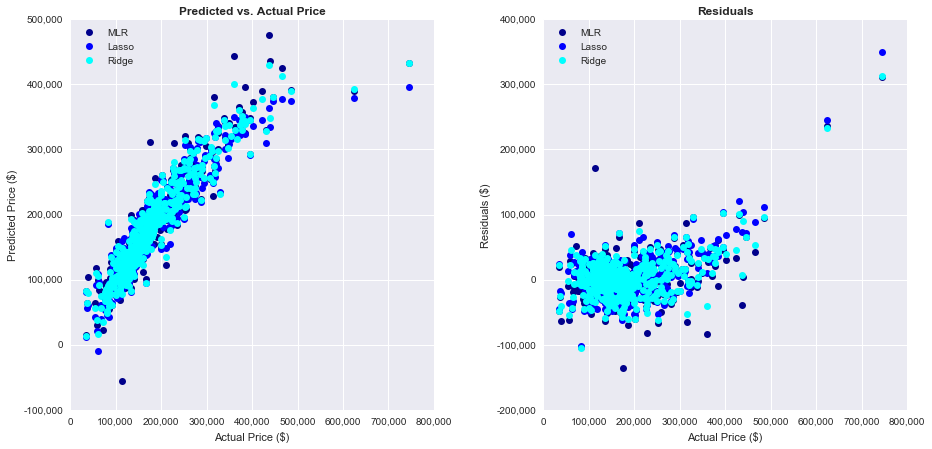

In [47]:
#Model residuals

MLRresiduals_reg = y_test - MLR_predict_reg
lassoResiduals_reg = y_test - lasso_predict_reg
ridgeResiduals_reg = y_test - ridge_predict_reg

# Plot residuals
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,MLR_predict_reg,"o",label='MLR', color='darkblue')
ax1.plot(y_test,lasso_predict_reg,"o",label='Lasso',color='blue')
ax1.plot(y_test,ridge_predict_reg,"o",label='Ridge',color='aqua')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLRresiduals_reg,"o",label='MLR',color='darkblue')
ax2.plot(y_test,lassoResiduals_reg,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals_reg,"o",label='Ridge',color='aqua')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [48]:
# Try predicting using log SalePrice
log_y_train = y_train.map(float).map(log)
log_y_train_LessMiscVal = y_train_LessMiscVal.map(float).map(log)

In [49]:
np.exp(MLR_predict_log+MiscVal_test)

NameError: name 'MLR_predict_log' is not defined

In [50]:
#Linear Regression
MLR =LinearRegression()
model_MLR_log = MLR.fit(X_train,log_y_train_LessMiscVal)
MLR_predict_log = model_MLR_log.predict(X_test)
MLR_predict_log = np.exp(MLR_predict_log)+MiscVal_test
MLR_RMSE_log = sqrt(mean_squared_error(y_test, MLR_predict_log))
print "MLR RMSE:",MLR_RMSE_log

#get best λ with LassoCV
lasso_cv_log = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv_log = lasso_cv_log.fit(X_train,ravel(log_y_train_LessMiscVal))
print "Lasso CV best λ:",model_cv_log.alpha_
lasso_predict_log= model_cv_log.predict(X_test)
lasso_predict_log=np.exp(lasso_predict_log)+MiscVal_test
lasso_RMSE_log = sqrt(mean_squared_error(y_test, lasso_predict_log))
print "Lasso RMSE:",lasso_RMSE_log

#get best λ with RidgeCV
ridge_cv_log = RidgeCV(cv=10)
ridge_model_cv_log = ridge_cv_log.fit(X_train,ravel(log_y_train_LessMiscVal))
print "Ridge CV best λ:",ridge_model_cv_log.alpha_
ridge_predict_log = ridge_model_cv_log.predict(X_test)
ridge_predict_log=np.exp(ridge_predict_log)+MiscVal_test
ridge_RMSE_log = sqrt(mean_squared_error(y_test, ridge_predict_log))
print "Ridge RMSE:",ridge_RMSE_log

MLR RMSE: 26791.950044
Lasso CV best λ: 0.00642314550235
Lasso RMSE: 31207.4004446
Ridge CV best λ: 10.0
Ridge RMSE: 26646.58906


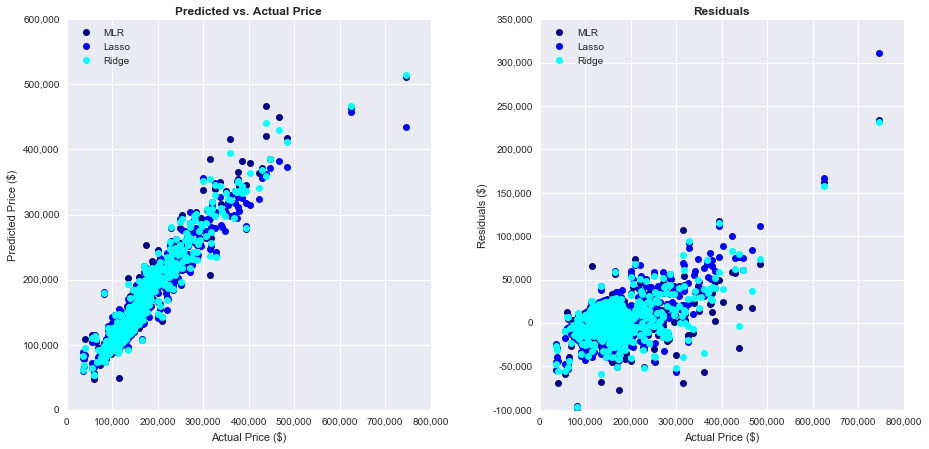

In [51]:
#residuals with log price models (in original scale)
MLRresiduals_log = y_test - MLR_predict_log
lassoResiduals_log = y_test - lasso_predict_log
ridgeResiduals_log = y_test - ridge_predict_log

# Plot residuals
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,MLR_predict_log,"o",label='MLR',color='darkblue')
ax1.plot(y_test,lasso_predict_log,"o",label='Lasso',color='blue')
ax1.plot(y_test,ridge_predict_log,"o",label='Ridge',color='aqua')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLRresiduals_log,"o",label='MLR',color='darkblue')
ax2.plot(y_test,lassoResiduals_log,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals_log,"o",label='Ridge',color='aqua')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [52]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_scaler = StandardScaler()
Y_train_scaled = ravel(y_scaler.fit_transform(y_train.reshape(-1, 1)))
Y_train_scaled_LessMiscVal = ravel(y_scaler.fit_transform(y_train_LessMiscVal.reshape(-1, 1)))
Y_test_scaled = ravel(y_scaler.transform(y_test.reshape(-1, 1)))
Y_test_scaled_LessMiscVal = ravel(y_scaler.transform(y_test_LessMiscVal.reshape(-1, 1)))

C:\Users\Vishwa\Anaconda2\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [53]:
# Run MLP using different hidden layer sizes
sizes = [(20,),(50,),(100,),(150,),(200,),(250,),(300,)]
RMSEs = []
for size in sizes:
    MLP = MLPRegressor(hidden_layer_sizes = size,activation='tanh',solver='sgd',learning_rate='constant',random_state=42,\
                       batch_size=40,learning_rate_init=0.001)
    model_MLP = MLP.fit(X_train_scaled,Y_train_scaled_LessMiscVal)
    MLP_predict = model_MLP.predict(X_test_scaled)
    MLP_predict = y_scaler.inverse_transform(MLP_predict)+MiscVal_test
    MLP_RMSE= sqrt(mean_squared_error(y_test, MLP_predict))
    RMSEs.append(MLP_RMSE)

C:\Users\Vishwa\Anaconda2\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [54]:
# Choosing hidden layer size with best RMSE
MLP = MLPRegressor(hidden_layer_sizes = sizes[np.argmin(RMSEs)],activation='tanh',solver='sgd',learning_rate='constant',random_state=42,\
                   batch_size=40,learning_rate_init=0.001)
model_MLP = MLP.fit(X_train_scaled,Y_train_scaled_LessMiscVal)
MLP_predict_scale = model_MLP.predict(X_test_scaled)
MLP_predict_scale = y_scaler.inverse_transform(MLP_predict_scale)+MiscVal_test
MLP_RMSE_scale = sqrt(mean_squared_error(y_test, MLP_predict_scale))
print "MLP RMSE:",MLP_RMSE_scale

MLPresiduals_scale = y_test - MLP_predict_scale

MLP RMSE: 36972.8645163


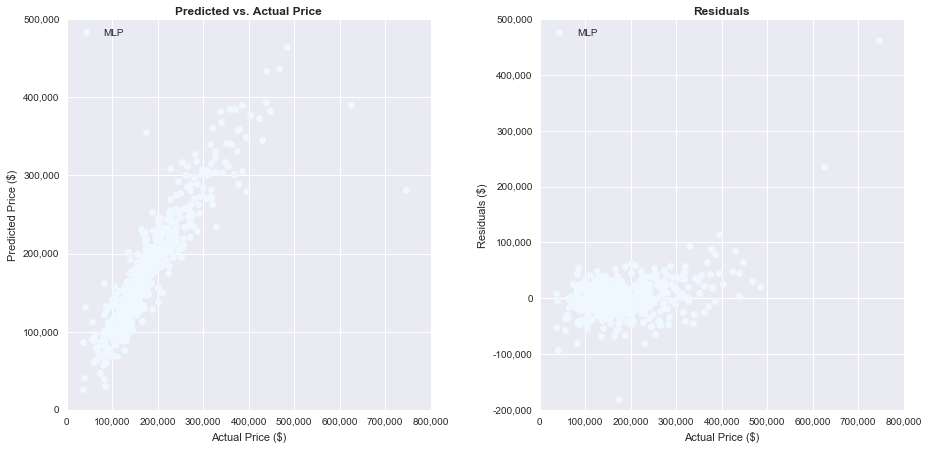

In [55]:
# Plot residuals
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,MLP_predict_scale,"o",label='MLP',color='aliceblue')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLPresiduals_scale, "o",label='MLP',color='aliceblue')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [56]:
# Try Linear Regression, Lasso, and Ridge with scaled X data

#Linear Regression
MLR =LinearRegression(fit_intercept=False)
model_MLR_scale = MLR.fit(X_train_scaled,y_train_LessMiscVal)
MLR_predict_scale = model_MLR_scale.predict(X_test_scaled)
MLR_predict_scale = MLR_predict_scale+MiscVal_test
MLR_RMSE_scale= sqrt(mean_squared_error(y_test, MLR_predict_scale))
print "MLR RMSE:",MLR_RMSE_scale

#get best λ with LassoCV
lasso_cv_scale = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv_scale = lasso_cv_scale.fit(X_train_scaled,ravel(y_train_LessMiscVal))
print "Lasso CV best λ:",model_cv_scale.alpha_
lasso_predict_scale = model_cv_scale.predict(X_test_scaled)
lasso_predict_scale=lasso_predict_scale+MiscVal_test
lasso_RMSE_scale= sqrt(mean_squared_error(y_test, lasso_predict_scale))
print "Lasso RMSE:",lasso_RMSE_scale

#get best λ with RidgeCV
ridge_cv_scale = RidgeCV(cv=10)
ridge_model_cv_scale = ridge_cv_scale.fit(X_train_scaled,ravel(y_train_LessMiscVal))
print "Ridge CV best λ:",ridge_model_cv_scale.alpha_
ridge_predict_scale= ridge_model_cv_scale.predict(X_test_scaled)
ridge_predict_scale=ridge_predict_scale+MiscVal_test
ridge_RMSE_scale= sqrt(mean_squared_error(y_test, ridge_predict_scale))
print "Ridge RMSE:",ridge_RMSE_scale

MLR RMSE: 182699.078057
Lasso CV best λ: 1136.86159119
Lasso RMSE: 32096.5099211
Ridge CV best λ: 10.0
Ridge RMSE: 33489.5446882


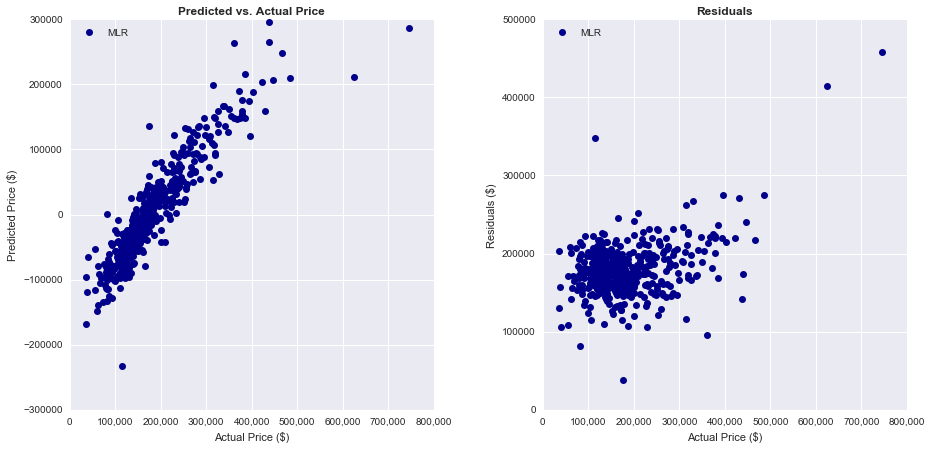

In [57]:
# Based on RMSE, it appears as though MLR may have challenges predicting this data
# For example, the linear regression problem could be under-determined 
#  (where the number of linearly independent rows of the training matrix 
#    is less than its number of linearly independent columns),
#  resulting in erroneous predictions

# Graph to see
MLRresiduals_scale = y_test - MLR_predict_scale
fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,MLR_predict_scale,"o",label='MLR',color='darkblue')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,MLRresiduals_scale, "o",label='MLR',color='darkblue')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

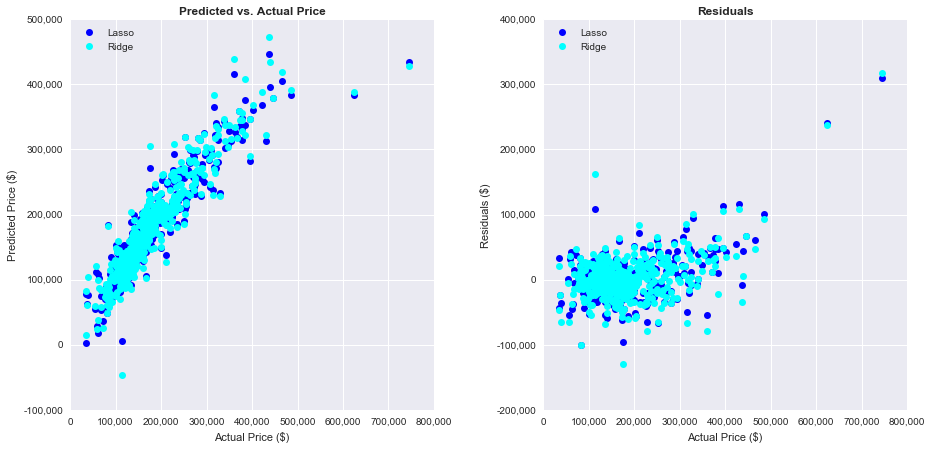

In [79]:
# Plot Lasso and Ridge
lassoResiduals_scale = y_test - lasso_predict_scale
ridgeResiduals_scale = y_test - ridge_predict_scale

fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,lasso_predict_scale,"o",label='Lasso',color='blue')
ax1.plot(y_test,ridge_predict_scale,"o",label='Ridge',color='aqua')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,lassoResiduals_scale,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals_scale,"o",label='Ridge',color='aqua')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

In [140]:
# Try fitting on scaled data and log SalePrice for Lasso and Ridge
#get best λ with LassoCV
lasso_cv_scalelog = LassoCV(alphas=None, cv=10, max_iter=10000)
model_cv_scalelog = lasso_cv_scalelog.fit(X_train_scaled,ravel(log_y_train_LessMiscVal))
print "Lasso CV best λ:",model_cv_scalelog.alpha_
lasso_predict_scalelog= model_cv_scalelog.predict(X_test_scaled)
lasso_predict_scalelog=np.exp(lasso_predict_scalelog)+MiscVal_test
lasso_RMSE_scalelog = sqrt(mean_squared_error(y_test, lasso_predict_scalelog))
print "Lasso RMSE:",lasso_RMSE_scalelog

#get best λ with RidgeCV
ridge_cv_scalelog = RidgeCV(cv=10)
ridge_model_cv_scalelog = ridge_cv_scalelog.fit(X_train_scaled,ravel(log_y_train_LessMiscVal))
print "Ridge CV best λ:",ridge_model_cv_scalelog.alpha_
ridge_predict_scalelog= ridge_model_cv_scalelog.predict(X_test_scaled)
ridge_predict_scalelog=np.exp(ridge_predict_scalelog)+MiscVal_test
ridge_RMSE_scalelog = sqrt(mean_squared_error(y_test, ridge_predict_scalelog))
print "Ridge RMSE:",ridge_RMSE_scalelog

Lasso CV best λ: 0.00369396284612
Lasso RMSE: 26190.5471312
Ridge CV best λ: 10.0
Ridge RMSE: 26934.2619722


In [141]:
for i, coef in enumerate(lasso_cv_scalelog.coef_):
    if i==0:
        pass
    elif coef==0.0 or coef==-0.0:
        pass
    else:
        print X.columns.values[i],coef

LotArea 0.0330311388912
Utilities -0.00446434304396
RoofStyle 0.00553832376387
Heating -0.00206376197919
CentralAir -0.00254434675466
1stFlrSF 0.0440934264875
GrLivArea 0.105794047076
KitchenQual -0.0163201621813
Age -0.0709803130718
AgeRem -0.0127332846551
MoSold_Jan -0.00464659282369
MoSold_Feb -0.000859647547577
MoSold_Jul 0.00022706869173
MoSold_Sept 0.00346742231062
MoSold_Oct -0.00382710525643
MoSold_Nov -0.000199276039991
RecessionResilient -0.00389899728246
RecessionSlightlyHelped 0.0140880833818
Drive_APave 0.0103995628473
Drive_AGrvl -0.00300385308938
LandLot_Reg -0.0055260523451
LandLot_BnkIrr -0.0201950811905
LandLot_HLSIR1 0.00344959130591
LandLot_HLSIR2 0.00277176135601
LandLot_HLSIR3 0.00135005616954
LandLot_LowIR1 0.00322101709857
LandLot_LowIR3 0.00163230407717
Conds_Pos -0.00675442172989
Conds_Neg -0.0207909299209
BsmtBath 0.0124346397835
TotBath 0.0222547399249
BsmtGLQUnfSF 0.0151078585441
Bunker 0.00189001254694
OverallCondQual 0.0844274884759
MasVnr_Stone 0.0051633

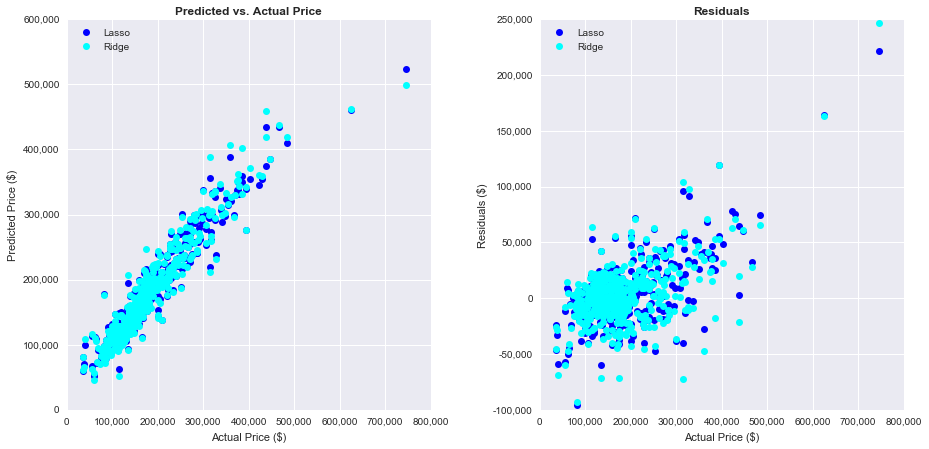

In [83]:
# Plot Lasso and Ridge results for scaled X data / log SalePrice
lassoResiduals_scalelog = y_test - lasso_predict_scalelog
ridgeResiduals_scalelog = y_test - ridge_predict_scalelog

fig = plt.figure(figsize=(15, 7))

# Predicted vs. Actual
ax1 = fig.add_subplot(121)
ax1.plot(y_test,lasso_predict_scalelog,"o",label='Lasso',color='blue')
ax1.plot(y_test,ridge_predict_scalelog,"o",label='Ridge',color='aqua')
ax1.legend(numpoints=1,loc='upper left')
ax1.set_ylabel('Predicted Price ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Predicted vs. Actual Price', fontsize=12, fontweight='bold')

# Residuals
ax2 = fig.add_subplot(122)
ax2.plot(y_test,lassoResiduals_scalelog,"o",label='Lasso',color='blue')
ax2.plot(y_test,ridgeResiduals_scalelog,"o",label='Ridge',color='aqua')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

fig.subplots_adjust(wspace=.3)
plt.show()

### SVR

In [64]:
SVR_reg = SVR(kernel='linear', C=10)
SVR_reg.fit(X_train,y_train_LessMiscVal)
SVR_predict_reg=SVR_reg.predict(X_test)
SVR_predict_reg=SVR_predict_reg+MiscVal_test
SVR_RMSE_reg=np.sqrt(mean_squared_error(y_test,SVR_predict_reg))
SVR_RMSE_reg

55794.026815552694

In [65]:
SVR_scale = SVR(kernel='linear', C=10)
SVR_scale.fit(X_train_scaled,y_train_LessMiscVal)
SVR_predict_scale=SVR_scale.predict(X_test_scaled)
SVR_predict_scale=SVR_predict_scale+MiscVal_test
SVR_RMSE_scale=np.sqrt(mean_squared_error(y_test,SVR_predict_scale))
SVR_RMSE_scale

52782.744316004202

In [ ]:
SVR_log = SVR(kernel='linear', C=10)
SVR_log.fit(X_train,ravel(log_y_train_LessMiscVal))
SVR_predict_log=SVR_log.predict(X_test)
SVR_predict_log=np.exp(SVR_predict_log)+MiscVal_test
SVR_RMSE_log=np.sqrt(mean_squared_error(y_test,SVR_predict_log))
SVR_RMSE_log

In [66]:
SVR_scalelog = SVR(kernel='linear', C=10)
SVR_scalelog.fit(X_train_scaled,ravel(log_y_train_LessMiscVal))
SVR_predict_scalelog=SVR_scalelog.predict(X_test_scaled)
SVR_predict_scalelog=np.exp(SVR_predict_scalelog)+MiscVal_test
SVR_RMSE_scalelog=np.sqrt(mean_squared_error(y_test,SVR_predict_scalelog))
SVR_RMSE_scalelog

24662.218397434714

### SGD Regressor

In [67]:
parameters = {'loss': ['squared_loss', 'huber'],
             'penalty': ['l1','l2'],
              'learning_rate': ['optimal','invscaling','constant']}
accuracy=make_scorer(mean_squared_error, greater_is_better=False)
SGDclf_reg = GridSearchCV(SGDRegressor(random_state=42), parameters, cv=5,scoring=accuracy)
SGDclf_reg.fit(X_train, y_train_LessMiscVal) 

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['squared_loss', 'huber'], 'learning_rate': ['optimal', 'invscaling', 'constant']},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

In [68]:
print SGDclf_reg.best_params_
print SGDclf_reg.best_score_

{'penalty': 'l1', 'loss': 'huber', 'learning_rate': 'optimal'}
-3797428011.69


In [69]:
GSCV_SGDclf_reg = SGDRegressor(loss='huber', penalty='l2', alpha=0.001, random_state=42)
GSCV_SGDclf_reg.fit(X_train, y_train_LessMiscVal)
GSCV_SGDclf_predict_reg = GSCV_SGDclf_reg.predict(X_test)
GSCV_SGDclf_predict_reg=GSCV_SGDclf_predict_reg+MiscVal_test
GSCV_SGDclf_RMSE_reg=np.sqrt(mean_squared_error(y_test, GSCV_SGDclf_predict_reg))
GSCV_SGDclf_RMSE_reg

190218.32082133982

In [70]:
parameters = {'loss': ['squared_loss', 'huber'],
             'penalty': ['l1','l2'],
              'alpha': [0.01, 0.001, 0.0001]
             }
accuracy=make_scorer(mean_squared_error, greater_is_better=False)
SGDclf_scale = GridSearchCV(SGDRegressor(random_state=42), parameters, cv=5,scoring=accuracy)
SGDclf_scale.fit(X_train_scaled, y_train_LessMiscVal)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=42, shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'loss': ['squared_loss', 'huber'], 'alpha': [0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

In [71]:
print SGDclf_scale.best_params_
print SGDclf_scale.best_score_

{'penalty': 'l2', 'alpha': 0.01, 'loss': 'squared_loss'}
-1404707182.91


In [72]:
GSCV_SGDclf_scale = SGDRegressor(penalty='l1', alpha=0.01, loss='huber', random_state=42)
GSCV_SGDclf_scale.fit(X_train_scaled, y_train_LessMiscVal)
GSCV_SGDclf_predict_scale = GSCV_SGDclf_scale.predict(X_test_scaled)
GSCV_SGDclf_predict_scale=GSCV_SGDclf_predict_scale+MiscVal_test
GSCV_SGDclf_RMSE_scale=np.sqrt(mean_squared_error(y_test, GSCV_SGDclf_predict_scale))
GSCV_SGDclf_RMSE_scale

199211.22479709802

In [73]:
# parameters = {'loss': ['squared_loss', 'huber'],
#              'penalty': ['l1','l2'],
#               'alpha': [0.01, 0.001, 0.0001]
#              }
# accuracy=make_scorer(mean_squared_error, greater_is_better=False)
# SGDclf_log = GridSearchCV(SGDRegressor(random_state=42), parameters, cv=5,scoring=accuracy)
# SGDclf_log.fit(X_train, log_y_train_LessMiscVal)

In [ ]:
# print SGDclf_log.best_params_
# print SGDclf_log.best_score_

In [ ]:
# ## NOT SURE OF BEST PARAMS -- LOG WOULDN'T RUN
# GSCV_SGDclf_log = SGDRegressor(penalty='l1', alpha=0.01, loss='huber', random_state=42)
# GSCV_SGDclf_log.fit(X_train, log_y_train_LessMiscVal)
# GSCV_SGDclf_predict_log = GSCV_SGDclf_log.predict(X_test)
# GSCV_SGDclf_predict_log=np.exp(GSCV_SGDclf_predict_log)+MiscVal_test
# GSCV_SGDclf_RMSE_log=np.sqrt(mean_squared_error(y_test, GSCV_SGDclf_predict_log))
# GSCV_SGDclf_RMSE_log

In [ ]:
# parameters = {'loss': ['squared_loss', 'huber'],
#              'penalty': ['l1','l2'],
#               'alpha': [0.01, 0.001, 0.0001]
#              }
# accuracy=make_scorer(mean_squared_error, greater_is_better=False)
# SGDclf_scalelog = GridSearchCV(SGDRegressor(random_state=42), parameters, cv=5,scoring=accuracy)
# SGDclf_scalelog.fit(X_train_scaled, log_y_train_LessMiscVal)

In [ ]:
# print SGDclf_scalelog.best_params_
# print SGDclf_scalelog.best_score_

In [ ]:
# ## NOT SURE OF BEST PARAMS -- LOG WOULDN'T RUN
# GSCV_SGDclf_scalelog = SGDRegressor(penalty='l1', alpha=0.01, loss='huber', random_state=42)
# GSCV_SGDclf_scalelog.fit(X_train_scaled, log_y_train_LessMiscVal)
# GSCV_SGDclf_predict_scalelog = GSCV_SGDclf_scalelog.predict(X_test_scaled)
# GSCV_SGDclf_predict_scalelog=np.exp(GSCV_SGDclf_predict_scalelog)+MiscVal_test
# GSCV_SGDclf_RMSE_scalelog=np.sqrt(mean_squared_error(y_test,GSCV_SGDclf_predict_scalelog))
# GSCV_SGDclf_RMSE_scalelog

### Regression Trees

In [74]:
# Create and fit the model
model_tree2_reg = DecisionTreeRegressor(random_state = 1)
model_tree2_reg.fit(X_train, y_train_LessMiscVal)

# Predict on the test set
p_tree2_reg = model_tree2_reg.predict(X_test)
p_tree2_reg=p_tree2_reg+MiscVal_test

# Calculate RMSE of the model
REGTREE_residuals_reg = y_test-p_tree2_reg
REGTREE_MSE_reg = (REGTREE_residuals_reg**2).mean()
REGTREE_RMSE_reg = math.sqrt(REGTREE_MSE_reg)

print "RMSE for Regression Tree is:", round(REGTREE_RMSE_reg,4)

RMSE for Regression Tree is: 48559.4118


In [75]:
# Create and fit the model
model_tree2_log = DecisionTreeRegressor(random_state = 1)
model_tree2_log.fit(X_train, log_y_train_LessMiscVal)

# Predict on the test set
p_tree2_log = model_tree2_log.predict(X_test)
p_tree2_log = np.exp(p_tree2_log)+MiscVal_test

# Calculate RMSE of the model
REGTREE_residuals_log = y_test-p_tree2_log
REGTREE_MSE_log = (REGTREE_residuals_log**2).mean()
REGTREE_RMSE_log = math.sqrt(REGTREE_MSE_log)

print "RMSE for Regression Tree USING LOG is:", round(REGTREE_RMSE_log,4)

RMSE for Regression Tree USING LOG is: 42189.3956


In [76]:
# Create and fit the model
model_tree2_scale = DecisionTreeRegressor(random_state = 1)
model_tree2_scale.fit(X_train_scaled, y_train_LessMiscVal)

# Predict on the test set
p_tree2_scale = model_tree2_scale.predict(X_test_scaled)
p_tree2_scale = p_tree2_scale+MiscVal_test

# Calculate RMSE of the model
REGTREE_residuals_scale = p_tree2_scale - y_test
REGTREE_MSE_scale = (REGTREE_residuals_scale**2).mean()
REGTREE_RMSE_scale = math.sqrt(REGTREE_MSE_scale)

print "RMSE with scaling Regression Tree is:", round(REGTREE_RMSE_scale,4)

RMSE with scaling Regression Tree is: 48542.7365


In [77]:
# Create and fit the model
model_tree2_scalelog = DecisionTreeRegressor(random_state = 1)
model_tree2_scalelog.fit(X_train_scaled, log_y_train_LessMiscVal)

# Predict on the test set
p_tree2_scalelog = model_tree2_scalelog.predict(X_test_scaled)
p_tree2_scalelog = np.exp(p_tree2_scalelog)+MiscVal_test

# Calculate RMSE of the model
REGTREE_residuals_scalelog = y_test - p_tree2_scalelog
REGTREE_MSE_scalelog = (REGTREE_residuals_scalelog**2).mean()
REGTREE_RMSE_scalelog = math.sqrt(REGTREE_MSE_scalelog)

print "RMSE with scaling for Regression Tree USING LOG is:", round(REGTREE_RMSE_scalelog,4)

RMSE with scaling for Regression Tree USING LOG is: 42191.1074


In [78]:
# # Feature importances from Model 1
# imp_tree1 = pd.Series(model_tree1.feature_importances_,X_train.columns.values)
# print imp_tree1.sort_values(ascending = False)[:10]

# Feature importances from Model 2
imp_tree2 = pd.Series(model_tree2_reg.feature_importances_,X_train.columns.values)
print imp_tree2.sort_values(ascending = False)[:10]

3CarGarage         0.340405
GrLivArea          0.216499
OverallCondQual    0.129307
1stFlrSF           0.064889
AgeRem             0.038405
Age                0.032806
MoSold_Jan         0.027103
BsmtGLQUnfSF       0.019264
TotBath            0.017042
LotArea            0.016421
dtype: float64


In [79]:
# SUMMARY - Regression Trees
print "RMSE for Regression Tree is:", round(REGTREE_RMSE_reg,4)
print "RMSE for Regression Tree USING LOG is:", round(REGTREE_RMSE_log,4)
print "RMSE with scaling Regression Tree is:", round(REGTREE_RMSE_scale,4)
print "RMSE with scaling for Regression Tree USING LOG is:", round(REGTREE_RMSE_scalelog,4)

RMSE for Regression Tree is: 48559.4118
RMSE for Regression Tree USING LOG is: 42189.3956
RMSE with scaling Regression Tree is: 48542.7365
RMSE with scaling for Regression Tree USING LOG is: 42191.1074


###  Random Forest (GridSearchCV)

In [80]:
# Cross validate RF model
# Set parameter dictionary to search through
params = {'n_estimators':[10,100,500, 1000], 'max_depth':[5,10,20]}

# Create model and fit best parameters
model_rf2 = RandomForestRegressor()
model_rf2_GS_reg = GridSearchCV(model_rf2, params)
model_rf2_GS_log = GridSearchCV(model_rf2, params)
model_rf2_GS_scale = GridSearchCV(model_rf2, params)
model_rf2_GS_scalelog = GridSearchCV(model_rf2, params)

In [81]:
# Avoid running, build a RF model below
model_rf2_GS_reg.fit(X_train, y_train_LessMiscVal)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100, 500, 1000], 'max_depth': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [82]:
# Avoid running, build a RF model below
model_rf2_GS_log.fit(X_train, log_y_train_LessMiscVal)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100, 500, 1000], 'max_depth': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [83]:
# Avoid running, build a RF model below
model_rf2_GS_scale.fit(X_train_scaled, y_train_LessMiscVal)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100, 500, 1000], 'max_depth': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [84]:
# Avoid running, build a RF model below
model_rf2_GS_scalelog.fit(X_train_scaled, log_y_train_LessMiscVal)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100, 500, 1000], 'max_depth': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [85]:
# Save best estimates to avoid re-running grid search
model_rf2_GS_reg_best=model_rf2_GS_reg.best_estimator_
model_rf2_GS_log_best=model_rf2_GS_log.best_estimator_
model_rf2_GS_scale_best=model_rf2_GS_scale.best_estimator_
model_rf2_GS_scalelog_best=model_rf2_GS_scalelog.best_estimator_

In [86]:
# Make predictions on Grid search optimized RF model
p_rf2_reg = model_rf2_GS_reg.predict(X_test)
p_rf2_reg = p_rf2_reg+MiscVal_test

# Calculate RMSE of the model
GS_RANDFOR_residuals_reg =  y_test-p_rf2_reg
GS_RANDFOR_MSE_reg = (GS_RANDFOR_residuals_reg**2).mean()
GS_RANDFOR_RMSE_reg = math.sqrt(GS_RANDFOR_MSE_reg)

print "RMSE for GS Random Forest is:", round(GS_RANDFOR_RMSE_reg,4)

RMSE for GS Random Forest is: 28024.3873


In [87]:
# Make predictions on Grid search optimized RF model
p_rf2_log = model_rf2_GS_log.predict(X_test)
p_rf2_log = np.exp(p_rf2_log)+MiscVal_test

# Calculate RMSE of the model
GS_RANDFOR_residuals_log = y_test - p_rf2_log
GS_RANDFOR_MSE_log = (GS_RANDFOR_residuals_log**2).mean()
GS_RANDFOR_RMSE_log = math.sqrt(GS_RANDFOR_MSE_log)

print "RMSE for GS Random Forest USING LOG is:", round(GS_RANDFOR_RMSE_log,4)

RMSE for GS Random Forest USING LOG is: 28633.5935


In [88]:
# Make predictions on Grid search optimized RF model
p_rf2_scale = model_rf2_GS_scale.predict(X_test_scaled)
p_rf2_scale = p_rf2_scale+MiscVal_test

# Calculate RMSE of the model
GS_RANDFOR_residuals_scale = y_test-p_rf2_scale
GS_RANDFOR_MSE_scale = (GS_RANDFOR_residuals_scale**2).mean()
GS_RANDFOR_RMSE_scale = math.sqrt(GS_RANDFOR_MSE_scale)

print "RMSE using scaling for GS Random Forest is:", round(GS_RANDFOR_RMSE_scale,4)

RMSE using scaling for GS Random Forest is: 28181.7702


In [89]:
# Make predictions on Grid search optimized RF model
p_rf2_scalelog = model_rf2_GS_scalelog.predict(X_test_scaled)
p_rf2_scalelog = np.exp(p_rf2_scalelog)+MiscVal_test

# Calculate RMSE of the model
GS_RANDFOR_residuals_scalelog = y_test - p_rf2_scalelog
GS_RANDFOR_MSE_scalelog = (GS_RANDFOR_residuals_scalelog**2).mean()
GS_RANDFOR_RMSE_scalelog = math.sqrt(GS_RANDFOR_MSE_scalelog)

print "RMSE using scaling for GS Random Forest USING LOG is:", round(GS_RANDFOR_RMSE_scalelog,4)

RMSE using scaling for GS Random Forest USING LOG is: 29042.8014


In [90]:
# SUMMARY - GridsearchCV on Random Forests
print "RMSE for GS Random Forest is:", round(GS_RANDFOR_RMSE_reg,4)
print "RMSE for GS Random Forest USING LOG is:", round(GS_RANDFOR_RMSE_log,4)
print "RMSE using scaling for GS Random Forest is:", round(GS_RANDFOR_RMSE_scale,4)
print "RMSE using scaling for GS Random Forest USING LOG is:", round(GS_RANDFOR_RMSE_scalelog,4)

RMSE for GS Random Forest is: 28024.3873
RMSE for GS Random Forest USING LOG is: 28633.5935
RMSE using scaling for GS Random Forest is: 28181.7702
RMSE using scaling for GS Random Forest USING LOG is: 29042.8014


### Gradient Boosting (GridSearchCV)

In [91]:
# Create Gradient Boosting Model
model_gb1 = GradientBoostingRegressor()

# Create parameter dictionary for GridSearchCV
params = {'n_estimators':(5,10,50,100,500,1000),'learning_rate':(0.01, 0.05, 0.1, 0.2)}

#Create Grid Search Model
model_gb1_GS = GridSearchCV(model_gb1,params)
model_gb1_GS_reg = GridSearchCV(model_gb1, params)
model_gb1_GS_log = GridSearchCV(model_gb1, params)
model_gb1_GS_scale = GridSearchCV(model_gb1, params)
model_gb1_GS_scalelog = GridSearchCV(model_gb1, params)

In [92]:
# Avoid running, build a RF model below
model_gb1_GS_reg.fit(X_train, y_train_LessMiscVal)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': (5, 10, 50, 100, 500, 1000), 'learning_rate': (0.01, 0.05, 0.1, 0.2)},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [93]:
# Avoid running, build a RF model below
model_gb1_GS_log.fit(X_train, log_y_train_LessMiscVal)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': (5, 10, 50, 100, 500, 1000), 'learning_rate': (0.01, 0.05, 0.1, 0.2)},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [94]:
# Avoid running, build a RF model below
model_gb1_GS_scale.fit(X_train_scaled, y_train_LessMiscVal)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': (5, 10, 50, 100, 500, 1000), 'learning_rate': (0.01, 0.05, 0.1, 0.2)},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [95]:
# Avoid running, build a RF model below
model_gb1_GS_scalelog.fit(X_train_scaled, log_y_train_LessMiscVal)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': (5, 10, 50, 100, 500, 1000), 'learning_rate': (0.01, 0.05, 0.1, 0.2)},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [96]:
# Save best estimates to avoid re-running grid search
model_gb1_GS_reg_best=model_gb1_GS_reg.best_estimator_
model_gb1_GS_log_best=model_gb1_GS_log.best_estimator_
model_gb1_GS_scale_best=model_gb1_GS_scale.best_estimator_
model_gb1_GS_scalelog_best=model_gb1_GS_scalelog.best_estimator_

In [97]:
# Make predictions on Grid search optimized Gradient Boosting model
p_gb1_reg = model_gb1_GS_reg.predict(X_test)
p_gb1_reg = p_gb1_reg+MiscVal_test

# Calculate RMSE of the model
GS_GRADBOOST_residuals_reg = y_test - p_gb1_reg
GS_GRADBOOST_MSE_reg = (GS_GRADBOOST_residuals_reg**2).mean()
GS_GRADBOOST_RMSE_reg = math.sqrt(GS_GRADBOOST_MSE_reg)

print "RMSE for GS Gradient Boosting is:", round(GS_GRADBOOST_RMSE_reg,4)

RMSE for GS Gradient Boosting is: 25259.7379


In [98]:
# Make predictions on Grid search optimized Gradient Boosting model
p_gb1_log = model_gb1_GS_log.predict(X_test)
p_gb1_log = np.exp(p_gb1_log)+MiscVal_test

# Calculate RMSE of the model
GS_GRADBOOST_residuals_log = y_test-p_gb1_log
GS_GRADBOOST_MSE_log = (GS_GRADBOOST_residuals_log**2).mean()
GS_GRADBOOST_RMSE_log = math.sqrt(GS_GRADBOOST_MSE_log)

print "RMSE for GS Gradient Boosting USING LOG is:", round(GS_GRADBOOST_RMSE_log,4)

RMSE for GS Gradient Boosting USING LOG is: 25096.6796


In [99]:
# Make predictions on Grid search optimized Gradient Boosting model
p_gb1_scale = model_gb1_GS_scale.predict(X_test_scaled)
p_gb1_scale = p_gb1_scale+MiscVal_test

# Calculate RMSE of the model
GS_GRADBOOST_residuals_scale = y_test - p_gb1_scale
GS_GRADBOOST_MSE_scale = (GS_GRADBOOST_residuals_scale**2).mean()
GS_GRADBOOST_RMSE_scale = math.sqrt(GS_GRADBOOST_MSE_scale)

print "RMSE with scaling for GS Gradient Boosting is:", round(GS_GRADBOOST_RMSE_scale,4)

RMSE with scaling for GS Gradient Boosting is: 25183.3798


In [100]:
# Make predictions on Grid search optimized Gradient Boosting model
p_gb1_scalelog = model_gb1_GS_scalelog.predict(X_test_scaled)
p_gb1_scalelog = np.exp(p_gb1_scalelog)+MiscVal_test

# Calculate RMSE of the model
GS_GRADBOOST_residuals_scalelog = y_test - p_gb1_scalelog
GS_GRADBOOST_MSE_scalelog = (GS_GRADBOOST_residuals_scalelog**2).mean()
GS_GRADBOOST_RMSE_scalelog = math.sqrt(GS_GRADBOOST_MSE_scalelog)

print "RMSE with scaling for GS Gradient Boosting USING LOG is:", round(GS_GRADBOOST_RMSE_scalelog,4)

RMSE with scaling for GS Gradient Boosting USING LOG is: 25349.1898


In [101]:
# SUMMARY - GridsearchCV on Gradient Boosting
print "RMSE for GS Gradient Boosting is:", round(GS_GRADBOOST_RMSE_reg,4)
print "RMSE for GS Gradient Boosting USING LOG is:", round(GS_GRADBOOST_RMSE_log,4)
print "RMSE with scaling for GS Gradient Boosting is:", round(GS_GRADBOOST_RMSE_scale,4)
print "RMSE with scaling for GS Gradient Boosting USING LOG is:", round(GS_GRADBOOST_RMSE_scalelog,4)

RMSE for GS Gradient Boosting is: 25259.7379
RMSE for GS Gradient Boosting USING LOG is: 25096.6796
RMSE with scaling for GS Gradient Boosting is: 25183.3798
RMSE with scaling for GS Gradient Boosting USING LOG is: 25349.1898


### AdaBoost

In [102]:
#predictions are on average 1.17 times as large as the actual value
parameters={'learning_rate': [0.01, 0.001, 0.0001], 'loss': ['linear', 'square']}
accuracy=make_scorer(mean_squared_error, greater_is_better=False)
GS_ADABOOST = GridSearchCV(AdaBoostRegressor(random_state=0), parameters, cv=5,scoring=accuracy)
GS_ADABOOST.fit(X_train, y_train_LessMiscVal)

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'loss': ['linear', 'square'], 'learning_rate': [0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=0)

In [103]:
GS_ADABOOST.best_params_

{'learning_rate': 0.01, 'loss': 'linear'}

In [104]:
GS_ADABOOST_reg=AdaBoostRegressor(random_state=1, loss='linear', learning_rate=0.01)
GS_ADABOOST_reg.fit(X_train, y_train_LessMiscVal)
GS_ADABOOST_predict_reg=GS_ADABOOST_reg.predict(X_test)
GS_ADABOOST_predict_reg=GS_ADABOOST_predict_reg+MiscVal_test
GS_ADABOOST_RMSE_reg=np.sqrt(np.mean((y_test-GS_ADABOOST_predict_reg)**2))
GS_ADABOOST_RMSE_reg

40965.453593454782

In [105]:
GS_ADABOOST_scale=AdaBoostRegressor(random_state=1, loss='linear', learning_rate=0.01)
GS_ADABOOST_scale.fit(X_train_scaled, y_train_LessMiscVal)
GS_ADABOOST_predict_scale = GS_ADABOOST_scale.predict(X_test_scaled)
GS_ADABOOST_predict_scale=GS_ADABOOST_predict_scale+MiscVal_test
GS_ADABOOST_RMSE_scale=np.sqrt(np.mean((y_test-GS_ADABOOST_predict_scale)**2))
GS_ADABOOST_RMSE_scale

41587.503785603963

In [106]:
GS_ADABOOST_log=AdaBoostRegressor(random_state=1, loss='linear', learning_rate=0.01)
GS_ADABOOST_log.fit(X_train, log_y_train_LessMiscVal)
GS_ADABOOST_predict_log = GS_ADABOOST_log.predict(X_test)
GS_ADABOOST_predict_log=np.exp(GS_ADABOOST_predict_log)+MiscVal_test
GS_ADABOOST_RMSE_log=np.sqrt(np.mean((y_test-GS_ADABOOST_predict_log)**2))
GS_ADABOOST_RMSE_log

44149.652508502186

In [107]:
GS_ADABOOST_scalelog=AdaBoostRegressor(random_state=1, loss='linear', learning_rate=0.01)
GS_ADABOOST_scalelog.fit(X_train_scaled, log_y_train_LessMiscVal)
GS_ADABOOST_predict_scalelog = GS_ADABOOST_scalelog.predict(X_test_scaled)
GS_ADABOOST_predict_scalelog=np.exp(GS_ADABOOST_predict_scalelog)+MiscVal_test
GS_ADABOOST_RMSE_scalelog=np.sqrt(np.mean((y_test-GS_ADABOOST_predict_scalelog)**2))
GS_ADABOOST_RMSE_scalelog

44149.905981014206

### MARS

In [108]:
# Best Model
MARS_scalelog = Earth(max_degree= 3,penalty=2.0,feature_importance_type = "rss",
                      smooth=True,enable_pruning=True)

MARS_scalelog_fit = MARS_scalelog.fit(X_train_scaled,log_y_train_LessMiscVal)

In [109]:
# Model Summary
print MARS_scalelog_fit.summary()
print MARS_scalelog_fit.summary_feature_importances(sort_by = 'rss')

Earth Model
----------------------------------------------------------------------------------------------------
Basis Function                                                                 Pruned  Coefficient  
----------------------------------------------------------------------------------------------------
(Intercept)                                                                    No      12.6298      
C(x8|s=+1,1.92073,2.06079,3.06549)                                             No      0.281409     
C(x8|s=-1,1.92073,2.06079,3.06549)                                             No      -0.20635     
x13                                                                            No      -0.145162    
C(x103|s=+1,-1.36808,1.96777,3.18081)                                          No      0.102728     
C(x103|s=-1,-1.36808,1.96777,3.18081)                                          No      -0.0870705   
C(x7|s=+1,-0.827562,2.0682,3.27567)                                            

In [110]:
MARS_predict_scalelog = MARS_scalelog_fit.predict(X_test_scaled)
MARS_predict_scalelog = np.exp(MARS_predict_scalelog)+MiscVal_test
MARS_RMSE_scalelog = np.sqrt(mean_squared_error(y_test,MARS_predict_scalelog))
print "The rmse for MARS is", MARS_RMSE_scalelog

The rmse for MARS is 23064.1786493


## MODEL COMPARISONS

In [111]:
models=['MLR','lasso','ridge','MLP','SVR','GSCV_SGDclf','MARS','REGTREE',
        'GS_ADABOOST','GS_GRADBOOST','GS_RANDFOR']
modelnames=['MLR','Lasso','Ridge','MLP','SVR','SGD Regression','MARS','Regression Tree',
            'Ada Boosting','Gradient Boost','Random Forest']
versions=['reg','log','scale','scalelog']
versionnames=['All Predictors','Log Price','Scaled Predictors','Scaled Predictors+LogPrice']
RMSEsummary_dict={}

for model in models:
    for version in versions:
        try:
            RMSE=eval(model+'_RMSE_'+version)
        except:
            RMSE='--'
        if version in RMSEsummary_dict.keys():
            RMSEsummary_dict[version].append(RMSE)
        else:
            RMSEsummary_dict[version]=[RMSE]


RMSEsummary=pd.DataFrame(RMSEsummary_dict,index=modelnames)
RMSEsummary=RMSEsummary.rename(columns=dict(zip(versions,versionnames)))
RMSEsummary=RMSEsummary[versionnames]
RMSEsummary

,All Predictors,Log Price,Scaled Predictors,Scaled Predictors+LogPrice
MLR,33506.3,26792,182699,--
Lasso,34027.6,31207.4,32096.5,26190.5
Ridge,31454.2,26646.6,33489.5,26934.3
MLP,--,--,36972.9,--
SVR,55794,--,52782.7,24662.2
SGD Regression,190218,--,199211,--
MARS,--,--,--,23064.2
Regression Tree,48559.4,42189.4,48542.7,42191.1
Ada Boosting,40965.5,44149.7,41587.5,44149.9
Gradient Boost,25259.7,25096.7,25183.4,25349.2


In [112]:
# Best Residuals
BMresiduals_GRADBOOST_scale=GS_GRADBOOST_residuals_scale
BMresiduals_MARS_scalelog=y_test-MARS_predict_scalelog
BMresiduals_LASSO_scalelog=lassoResiduals_scalelog

# Worst Residuals
WMresiduals_SVR_scale=y_test-SVR_predict_scale
WMresiduals_ADABOOST_log=y_test-GS_ADABOOST_predict_log
WMresiduals_SGD_reg=y_test-GSCV_SGDclf_predict_reg

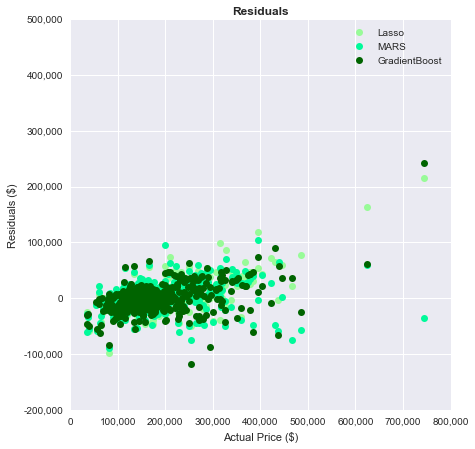

In [113]:
# Plot Residuals - Best Models
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
ax1.plot(y_test,BMresiduals_LASSO_scalelog,"o",label='Lasso',color='palegreen')
ax1.plot(y_test,BMresiduals_MARS_scalelog,"o",label='MARS',color='mediumspringgreen')
ax1.plot(y_test,BMresiduals_GRADBOOST_scale,"o",label='GradientBoost', color='darkgreen')
ax1.legend(numpoints=1,loc='upper right')
ax1.set_ylabel('Residuals ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_ylim([-200000,500000])
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Residuals', fontsize=12, fontweight='bold')

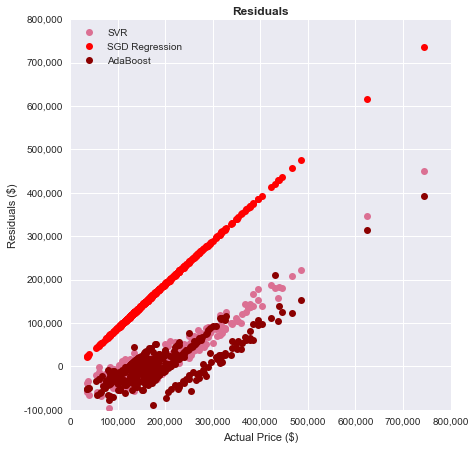

In [114]:
# Plot Residuals - Worst Models
fig = plt.figure(figsize=(15, 7))
ax2 = fig.add_subplot(121)
ax2.plot(y_test,WMresiduals_SVR_scale,"o",label='SVR',color='palevioletred')
ax2.plot(y_test,WMresiduals_SGD_reg,"o",label='SGD Regression',color='red')
ax2.plot(y_test,WMresiduals_ADABOOST_log,"o",label='AdaBoost', color='darkred')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')

# Cross-validating Best Models and Creating Kaggle Submissions

In [126]:
X_comp['BsmtBath'] = X_comp['BsmtBath'].fillna(0.0)
X_comp['TotBath'] = X_comp['TotBath'].fillna(0.0)

In [124]:
# Pull out MiscVal
MiscVal_train = X['MiscVal']
X = X.drop('MiscVal',1)
y_LessMiscVal = y - MiscVal_train


MiscVal_comp = X_comp['MiscVal']
X_comp = X_comp.drop('MiscVal',1)

In [127]:
# Transforming entire train set
log_y = y_LessMiscVal.map(float).map(log)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_comp_scaled = scaler.transform(X_comp)

In [128]:
# Create parameter dictionary for GridSearchCV
params = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'),'C':(.01,.1,1,10)}
SVR_scalelog = GridSearchCV(SVR(), params).fit(X_scaled,ravel(log_y))
SVRmodel = SVR_scalelog.best_estimator_

In [129]:
#K-Fold validation for SVR (scale_log)

kf = KFold(n_splits=5)

scores=[]
for train_index, test_index in kf.split(X_scaled):
    X_tr, X_ts = X_scaled[train_index], X_scaled[test_index]
    misc_tr, misc_ts = MiscVal_train[train_index], MiscVal_train[test_index]
    y_tr, y_ts = log_y[train_index], log_y[test_index]
    model=SVRmodel.fit(X_tr,ravel(y_tr))
    predict=model.predict(X_ts)
    rmse = sqrt(mean_squared_error((np.exp(y_ts)+misc_ts), (np.exp(predict)+misc_ts)))
    scores.append(rmse)
    
print scores
print mean(scores)

[22228.604404827871, 36041.214808565353, 31360.446567994237, 22345.60804562092, 47525.448077130357]
31900.2643808


In [130]:
# Best Model
MARS_scalelog = Earth(max_degree= 3,penalty=2.0,feature_importance_type = "rss",
                      smooth=True,enable_pruning=True)

MARS_scalelog_fit = MARS_scalelog.fit(X_scaled,log_y)

In [131]:
#K-Fold validation for MARS (scale_log)

kf = KFold(n_splits=5)

scores=[]
for train_index, test_index in kf.split(X_scaled):
    X_tr, X_ts = X_scaled[train_index], X_scaled[test_index]
    misc_tr, misc_ts = MiscVal_train[train_index], MiscVal_train[test_index]
    y_tr, y_ts = log_y[train_index], log_y[test_index]
    model=MARS_scalelog.fit(X_tr,ravel(y_tr))
    predict=model.predict(X_ts)
    rmse = sqrt(mean_squared_error((np.exp(y_ts)+misc_ts), (np.exp(predict)+misc_ts)))
    scores.append(rmse)
    
print scores
print mean(scores)

[23124.209142613407, 45020.215359469468, 28499.938270508355, 19979.763850052208, 28167.370491128833]
28958.2994228


In [134]:
MARS_scalelog_fit = MARS_scalelog.fit(X_scaled,log_y)
MARS_scalelog_pred = list(np.exp(MARS_scalelog_fit.predict(X_comp_scaled))+MiscVal_comp)

# Save predictions to file
outfile = open('MARS_scalelog_pred.csv', 'w')
for item in MARS_scalelog_pred:
    outfile.write("%s\n" % item)
outfile.close()

In [132]:
# Create parameter dictionary for GridSearchCV
params = {'n_estimators':(5,10,50,100,500,1000),'learning_rate':(0.01, 0.05, 0.1, 0.2),'min_samples_leaf':(1,5,10,20)}
gradientBoost_scalelog = GridSearchCV(GradientBoostingRegressor(), params).fit(X_scaled,ravel(y))
GBmodel2 = gradientBoost_scalelog.best_estimator_

In [133]:
#K-Fold validation for Gradient Boosting (scale)

kf = KFold(n_splits=5)

scores=[]
for train_index, test_index in kf.split(X_scaled):
    X_tr, X_ts = X_scaled[train_index], X_scaled[test_index]
    misc_tr, misc_ts = MiscVal_train[train_index], MiscVal_train[test_index]
    y_tr, y_ts = y[train_index], y[test_index]
    model=GBmodel2.fit(X_tr,ravel(y_tr))
    predict=model.predict(X_ts)
    rmse = sqrt(mean_squared_error(y_ts, predict+misc_ts))
    scores.append(rmse)
    
print scores
print mean(scores)

[23106.811257402438, 37138.153309115281, 31159.147467337621, 20742.870071811176, 27388.154778691955]
27907.0273769


In [137]:
lasso_cv_scalelog = LassoCV(alphas=None, cv=15, max_iter=10000).fit(X_scaled,ravel(log_y))
lasso_cv_scalelog.alpha_

0.0041351065015407104

In [136]:
#K-Fold validation for Lasso (scale_log)

kf = KFold(n_splits=5)

scores=[]
for train_index, test_index in kf.split(X_scaled):
    X_tr, X_ts = X_scaled[train_index], X_scaled[test_index]
    misc_tr, misc_ts = MiscVal_train[train_index], MiscVal_train[test_index]
    y_tr, y_ts = log_y[train_index], log_y[test_index]
    lasso = Lasso(alpha=lasso_cv_scalelog.alpha_)
    model=lasso.fit(X_tr,ravel(y_tr))
    predict=model.predict(X_ts)
    rmse = sqrt(mean_squared_error((np.exp(y_ts)+misc_ts), (np.exp(predict)+misc_ts)))
    scores.append(rmse)
    
print scores
print mean(scores)

[22602.246296805093, 35283.004740546443, 31630.880920026408, 23636.148686545639, 41147.530296344587]
30859.9621881


In [138]:
lassoPred4 = list(np.exp(lasso_cv_scalelog.predict(X_comp_scaled))+MiscVal_comp)

# Save predictions to file
outfile = open('lassoPred4.csv', 'w')
for item in lassoPred4:
    outfile.write("%s\n" % item)
outfile.close()

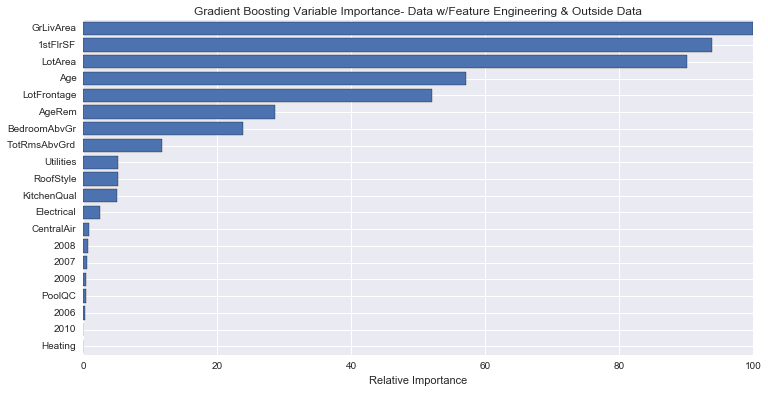

In [144]:
feature_importance = GBmodel2.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_importance = feature_importance[:20]
#print feature_importance
sorted_idx = np.argsort(feature_importance)
#sorted_idx = sorted_idx
#print sorted_idx
list_columns=list(X.columns.values)

pos = np.arange(sorted_idx.shape[0]) + .5

feature_names=[]
for i in range(len(sorted_idx)):
    feature_names.append(list_columns[sorted_idx[i]])
#print feature_names
#print feature_importance[sorted_idx]
#plt.subplot(1, 2, 2)
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names)

plt.xlabel('Relative Importance')
plt.title('Gradient Boosting Variable Importance- Data w/Feature Engineering & Outside Data')
plt.show()

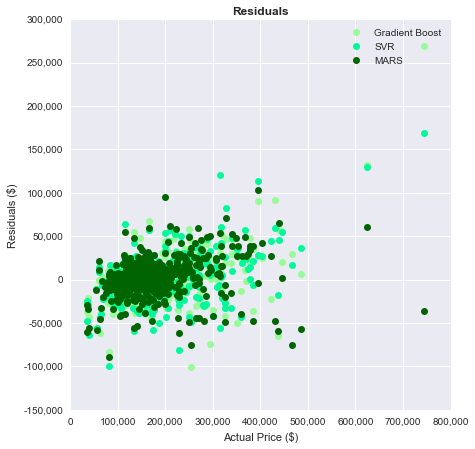

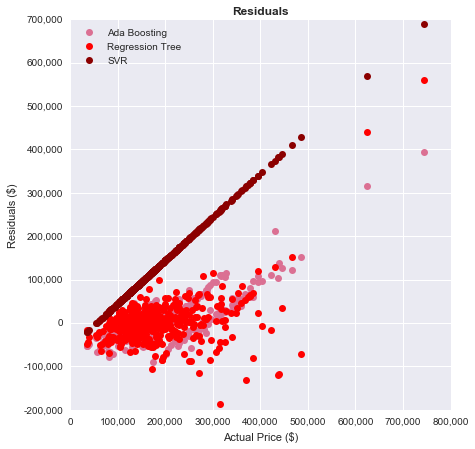

In [145]:
## Best
BMresiduals_MARS_scalelog=y_test-MARS_predict_scalelog
BMresiduals_GRADBOOST_log=y_test-p_gb1_log
BMresiduals_SVR_scalelog=y_test-SVR_predict_scalelog

# Plot Residuals - Best Models
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
ax1.plot(y_test,BMresiduals_GRADBOOST_log,"o",label='Gradient Boost',color='palegreen')
ax1.plot(y_test,BMresiduals_SVR_scalelog,"o",label='SVR',color='mediumspringgreen')
ax1.plot(y_test,BMresiduals_MARS_scalelog,"o",label='MARS', color='darkgreen')
ax1.legend(numpoints=1,loc='upper right')
ax1.set_ylabel('Residuals ($)')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_xlabel('Actual Price ($)')
ax1.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax1.set_title('Residuals', fontsize=12, fontweight='bold')

## Worst
WMresiduals_SVR_reg=y_test-SVR_RMSE_reg
WMresiduals_REGTREE_reg=y_test-p_tree2_reg
WMresiduals_ADABOOST_scalelog=y_test-GS_ADABOOST_predict_scalelog

# Plot Residuals - Worst Models
fig = plt.figure(figsize=(15, 7))
ax2 = fig.add_subplot(121)
ax2.plot(y_test,WMresiduals_ADABOOST_scalelog,"o",label='Ada Boosting',color='palevioletred')
ax2.plot(y_test,WMresiduals_REGTREE_reg,"o",label='Regression Tree',color='red')
ax2.plot(y_test,WMresiduals_SVR_reg,"o",label='SVR', color='darkred')
ax2.legend(numpoints=1,loc='upper left')
ax2.set_ylabel('Residuals ($)')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_xlabel('Actual Price ($)')
ax2.xaxis.set_major_formatter(mtick.FuncFormatter('{:,.0f}'.format))
ax2.set_title('Residuals', fontsize=12, fontweight='bold')